# Decoding Individual Identity
Tim Tyree<br>
9.9.2022

(~5-10 minute read)<br>

Add 15 minutes if you want to run all cells ('Kernel>Restart & Run All').

In [1]:
from lib.get_init import *
%load_ext autoreload
%autoreload 2
np.random.seed(42)

In [2]:
#reset matplotlib settings
sns.reset_orig()
mpl.rc_file_defaults()

# select the data

In [3]:
#optionally, use a popup window to select data.json
use_search_dialog=True
if use_search_dialog:
    print(f"Please select 'data.json' using the popup window launched by search_for_file")
    from lib.controller.filedialog import search_for_file
    #nota bene: restarting the .ipynb should make the widget window go away
    data_dir = search_for_file (currdir = os.getcwd())
    print(f"{data_dir=}")
else:
    data_dir='/Users/timothytyree/Documents/TyreeEtAl_data/data.json'


Please select 'data.json' using the popup window launched by search_for_file
File: /Users/timothytyree/Documents/TyreeEtAl_data/data.json
data_dir='/Users/timothytyree/Documents/TyreeEtAl_data/data.json'


In [4]:
print(f"{data_dir=}")
assert os.path.exists(data_dir)

data_dir='/Users/timothytyree/Documents/TyreeEtAl_data/data.json'


# load the data

_schema of data.json:_
- observer_name: name of the observer
- session_num: integer index of recording session
- dict_anatomical: anatomical information for recording session
- dict_relationships: relationship information confirmed between observers and conspecifics
- dict_transcript: spike times for all neurons labeled by trial, trial information
    - spike_time_array: table containing neuron spike times centered at stimulus onset t=0. rows index trials. columns index neurons.
    - df_trial_data: table of trial information. rows index trials.
    - df_labels: table of trial labels computed from trial information. rows index trials.
- dict_error_estimates: estimated spike sorting error rates (percent of oversplit or undersplit neurons)
- dict_subpopulations: dictionary of neurons identified as concept cells or responsive to face or voice stimuli
- dict_decoder_hyperparameters: dictionary of decoder hyperparameter settings
- dict_etc:
    - df_neurons: table of information describing all neurons.  rows index neurons.
    - dict_spike_templates: dictionary of spike sorting templates for all neurons.
        - t_values: time values centered at the waveform peak
        - dict_spike_template_lst: list spike template dictionaries ordered by neuron
        - xdim: units of t_values are in milliseconds.
        - ydim: units of spike templates are in millivolts.
        - flip_signs: true if original spike template was multiplied by -1, which typically lead to spikes appearing as a maximum instead of as a minimum value.

In [5]:
#load data from .json
data=load_from_json(data_dir)
observer_name = data['observer_name']
session_num = data['session_num']
print(f"This dataset was loaded from {data_dir=}.")
print(f"\nObserver: {observer_name.capitalize()} (Session #{session_num+1})") # session_num+1 - the first recording session had session_num=0.
print(f"\n------------------------------\n")
print(f"\ndata has the following keys:")
for key in data:
    print(key)
print(f"\ndict_anatomical holds anatoml data for recoring session:")
print_dict(data['dict_anatomical'])

This dataset was loaded from data_dir='/Users/timothytyree/Documents/TyreeEtAl_data/data.json'.

Observer: Hades (Session #46)

------------------------------


data has the following keys:
session_num
observer_name
dict_anatomical
dict_relationships
dict_transcript
dict_error_estimates
dict_subpopulations
dict_decoder_hyperparameters
dict_etc

dict_anatomical holds anatoml data for recoring session:
session_num=45
anatomical_region='CA1'
AP_pos_set=-3.1


__Anatomical location in Hippocampus:__

The estimated centroid of the microwire brush array was used to determine anatomical location of a recording session.  The anterior-posterior (`AP_pos`) position was estimated (in millimeters), and if we had great confidence that the majority of the array was recording predominantly in one hippocampal 
subfield, then we labeled the recording session with the appropriate subfield (`anatomical_region`).  If `anatomical_region=''`, then we did not have this great confidence for any of the subfields located in the hippocampus.

<!-- __Nota bene__: <br>The recording session previous to Session #47 (Session #46) was prodominantly in CA1 (i.e. `anatomical_region='CA1`).
 -->
<!--  ![image.png](attachment:image.png). -->

In [6]:
print(f"dict_transcript has the following keys:")
for key in data['dict_transcript']:
    print(key)
    
#load spike data from the dict_transcript
spike_time_array = np.array(data['dict_transcript']['spike_time_array'])
#caste spike time array to numpy.array of numpy.array instances
for i in range(spike_time_array.shape[0]):
    for j in range(spike_time_array.shape[1]):
        if type(spike_time_array[i,j])==float:
            spike_time_array[i,j] = np.array([spike_time_array[i,j]])
        else:
            spike_time_array[i,j] = np.array(spike_time_array[i,j])

#load trial data from from the dict_transcript
df_trial_data = pd.DataFrame(data['dict_transcript']['df_trial_data'])\
    .drop(columns=['PheeName','index'])\
    .reset_index(drop=True)  
df_labels = pd.DataFrame(data['dict_transcript']['df_labels'])\
    .reset_index(drop=True)
df_trial_data.head()

dict_transcript has the following keys:
spike_time_array
df_trial_data
df_labels


,Duration,block,imDur,imMatchFlag,imName,imNum,novel,session_num,trial_num,monkName,faceName,pheeName
0,2.590260,1.0,2.590260,3.0,none,1.0,1,45,0,Hades,none,chewie
1,3.503553,1.0,3.503553,0.0,Jenny,2.0,1,45,1,Hades,jenny,none
2,3.507905,1.0,3.507905,0.0,Chewie,3.0,1,45,2,Hades,chewie,none
3,3.502131,1.0,3.502131,0.0,Hermes,4.0,1,45,3,Hades,hermes,none
4,2.666507,1.0,2.666507,3.0,none,5.0,1,45,4,Hades,none,hank


# count spikes by both neuron and trial

In [7]:
#count the number of spikes in each trial for each neuron
min_refractory_period = 1/150 #150 Hz max firing rate
spike_count_array,error_code_array = count_spike_count_errs(spike_time_array,
                                    min_refractory_period = min_refractory_period)

In [8]:
#generate xy coordinate grids
num_trials,num_neurons = error_code_array.shape
xcoord_values = np.arange(num_trials+1)  #as corners of pixels
ycoord_values = np.arange(num_neurons+1) #as corners of pixels
x, y = np.meshgrid(xcoord_values, ycoord_values)
y=y[::-1,::-1].copy() #flip y axis
z=spike_count_array.copy().T
zerr=error_code_array.copy().T

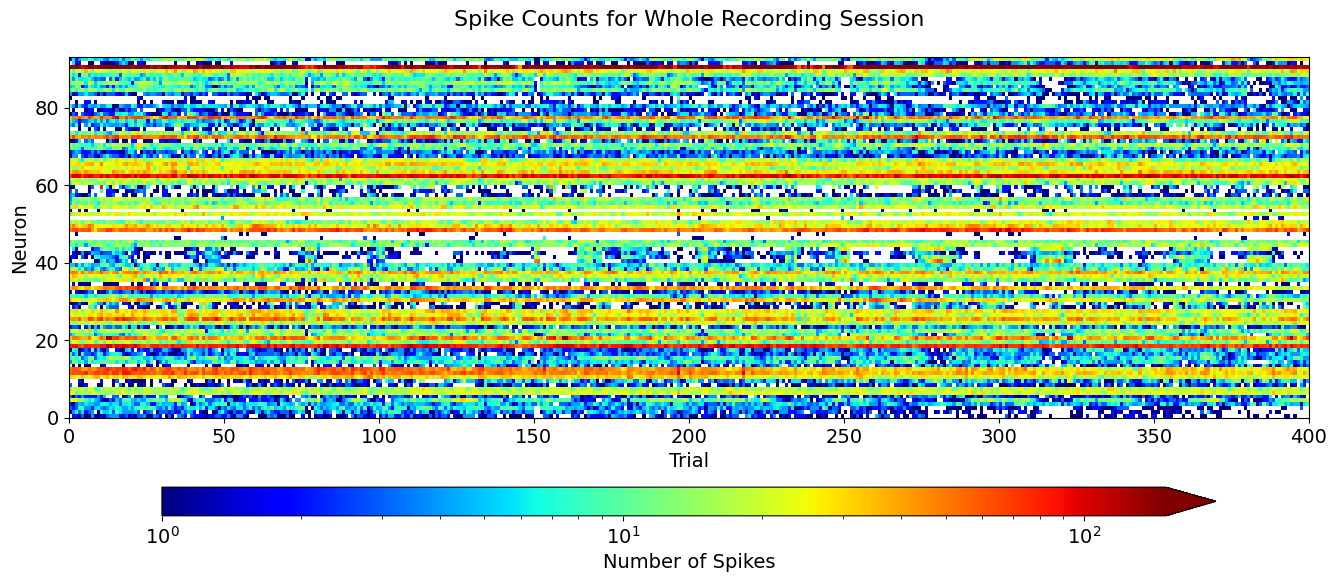

In [9]:
#visualize heatmap showing the number of spikes per trial,neuron pair
title = 'Spike Counts for Whole Recording Session\n'
vmin=1.
vmax=150.
figsize=(16,6)
cmap='jet'
fig, ax = plt.subplots(figsize=figsize,constrained_layout=True)
ax = GridValuePlotter_colorbar(fig,ax,x,y,z,title,cmap,vmin,vmax,
        fontsize=14,xlabel='Trial',ylabel='Neuron')
plt.show()

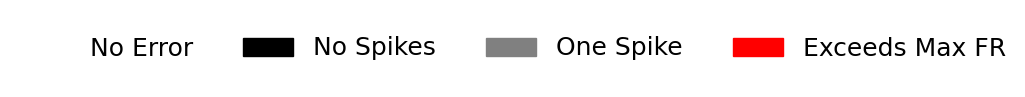

In [10]:
# define discrete color map for error codes
dict_error_labels = {0:'No Error', 1:'No Spikes', 2:'One Spike', 3:'Exceeds Max FR'}
dict_error_colors = {0:'white', 1:'black', 2:'gray', 3:'red'}
levels=list(dict_error_colors.keys())
levels.append(np.max(levels)+1)
cmap, norm = mpl.colors.from_levels_and_colors(levels=levels, 
                                               colors=list(dict_error_colors.values()), 
                                               extend='neither')
#show legend for error codes
label_lst=list(dict_error_labels.values())
color_lst=list(dict_error_colors.values())
kwargs_legend={
    'frameon':False,
    'loc':'center',
    'ncol':len(label_lst),
    'fontsize':18}
PlotLegend(label_lst=label_lst,color_lst=color_lst,**kwargs_legend);

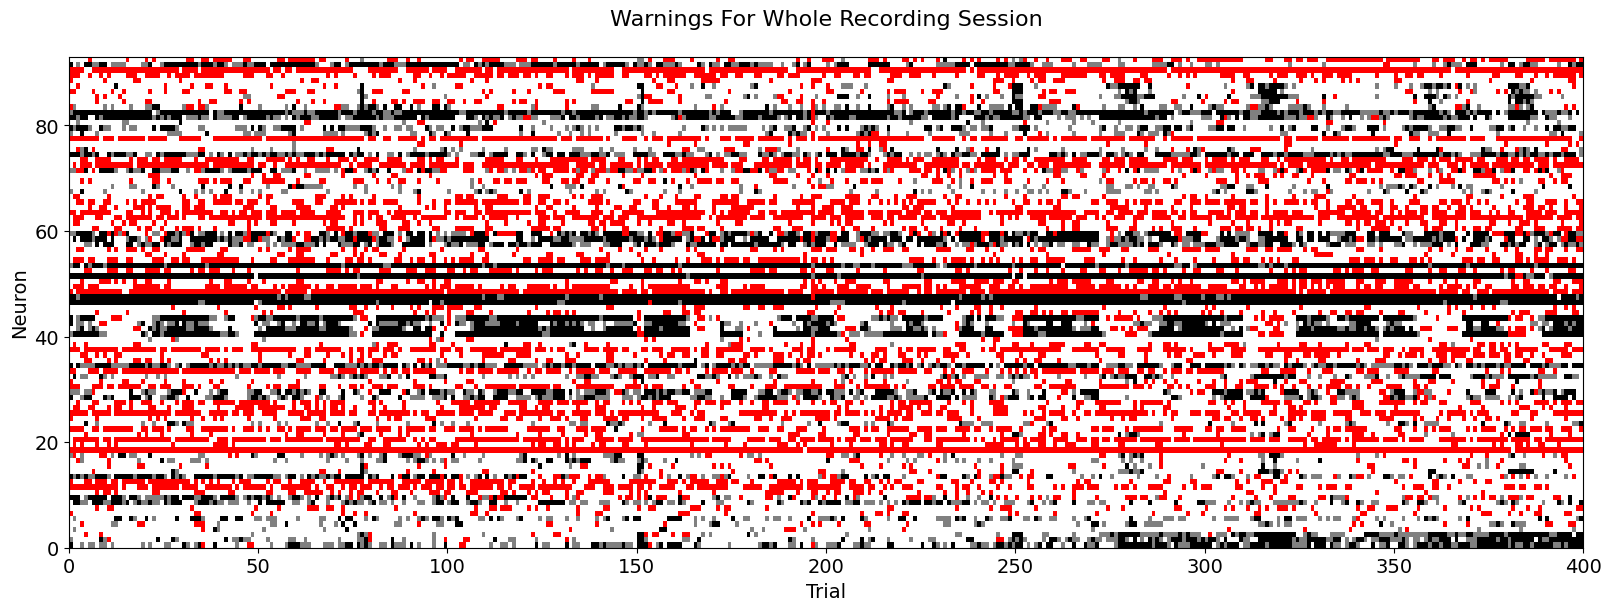

In [11]:
#visualize heatmap showing error codes of any neuron pair
title = 'Warnings For Whole Recording Session\n'
fig, ax = plt.subplots(figsize=figsize,constrained_layout=True)
GridValuePlotter_simple(ax,x,y,zerr,title,cmap,norm,
        fontsize=14,xlabel='Trial',ylabel='Neuron')
plt.show()

# identify any obvious recording errors that warrant removal

Obvious recording errors to look out for: 

1. (red vertical bars) trials that exceed the max firing rate for all or nearly all neurons,

1. (red horizontal bars) neurons that exceed the max firing rate for all or nearly all trials,

1. (black horizontal bars) neurons that do not fire for an entire recording block or more.


In [12]:
max_block_size = pd.DataFrame(data['dict_transcript']['df_trial_data']).groupby(by='block').count().max().values[0]
print(f"{max_block_size=} trials")

max_block_size=20 trials


## red horizontal bar trials

identify trials and neurons with unreasonably high firing rates for an overwhelming majority of the trials.<br>
doing so can potentially identify severly undersplit neurons.

In [13]:
#choose filter for trials that fired unreasonably fast (error_code==3)
max_count_err_3_by_trial=75
count_err_3_by_trial  = np.sum (error_code_array==3,axis=1)

# boot is True when trial is to be removed
boot = (count_err_3_by_trial  > max_count_err_3_by_trial).flatten()

#generate list of trials to be removed
trial_num_values_reasonable  = np.argwhere(~boot).flatten()
trial_num_values_unreasonable = np.argwhere(boot).flatten()
num_trials_reasonable  = trial_num_values_reasonable.shape[0]
num_trials_unreasonable = trial_num_values_unreasonable.shape[0]
print(f"\t{num_trials_reasonable=} (keep) \t{num_trials_unreasonable=} (remove)")

	num_trials_reasonable=400 (keep) 	num_trials_unreasonable=0 (remove)


## undersplit type neurons (multiunits)

the results in the main text were robust to multiunits identified by low to moderate abundances of interspike intervals <br>
that are briefer than the minimum refractory period.  this supports some multiunits as carrying meaningful information.  

however, there is reason to believe that severely undersplit neurons can increase trial-to-trial variance, <br>
which will inhibit/hinder any randomized predictive study, which warrants their removal.

In [14]:
#choose filter for neurons that are unreasonable (firing too often)
max_count_err_3_by_neuron=300
count_err_3_by_neuron = np.sum (error_code_array==3,axis=0)
boon3 = count_err_3_by_neuron > max_count_err_3_by_neuron
print(f"\tnum_neurons_reasonable={boon3.shape[0]-sum(boon3)} (keep), \tnum_neurons_unreasonable={sum(boon3)} (remove)")

	num_neurons_reasonable=86 (keep), 	num_neurons_unreasonable=7 (remove)


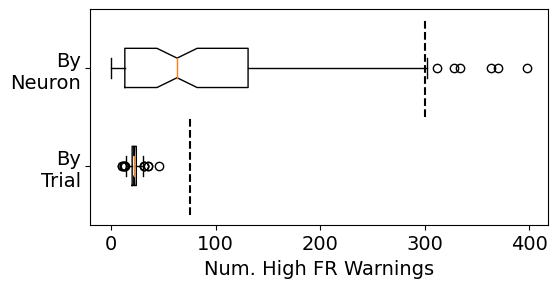

In [15]:
x1_values=count_err_3_by_trial
x2_values=count_err_3_by_neuron
x1_thresh=max_count_err_3_by_trial
x2_thresh=max_count_err_3_by_neuron
x1_label='By\nTrial'
x2_label='By\nNeuron'
figsize=(5.9,2.8)
fig,ax=plt.subplots(figsize=figsize)
#plot thresholds
ax.plot([x1_thresh,x1_thresh],[-0.5,0.5],'k--')
ax.plot([x2_thresh,x2_thresh],[0.5,1.5],'k--')
#plot boxplots
ax = BoxplotPairPlotter_simple(ax,x1_values,x2_values,x1_label,x2_label,position1=0,position2=1,
                              xlabel='Num. High FR Warnings',ylabel='',fontsize=14)
plt.show()

to address (2.), we counted the number of times a neuron fires faster than the estimated minimum refractory period.<br>
Q: does (lower black dotted) max_count_err_3_by_neuron look reasonable for this recording session?


## oversplit type neurons (deadunits)

increasing max_streak_length geneerally increases the number of neurons removed for not firing.  neurons might stop firing for long periods of time if they die, the monkey moved the wrong way between recording blocks, or if the neuron was severely oversplit.

In [16]:
#identify unreasonably low firing rates
df_es = identify_obvious_recording_warnings_from_session(error_code_array,spike_count_array,
                                             max_count_err_3_by_trial=max_count_err_3_by_trial,
                                             max_count_err_3_by_neuron=max_count_err_3_by_neuron,
                                             printing=True)
print(f"Q: did some neurons failed to fire for many recording sessions in a row?...\n\t\t\t...if so, they should be removed from further consideration.")
print(f"\nany recording block had no more than these many trials:")
print(f"\t\t\t{max_block_size=}")
df_es.sort_values(by='longest_error_streak',ascending=False).head(10)

Q: did some neurons failed to fire for many recording sessions in a row?...
			...if so, they should be removed from further consideration.

any recording block had no more than these many trials:
			max_block_size=20


,nid,longest_error_streak,final_error_streak,max_spike_count
39,39,226,103,2
41,41,199,9,6
45,45,196,6,3
46,46,166,166,7
10,10,137,0,11
90,90,55,2,13
18,18,53,1,6
52,52,48,11,66
49,49,47,12,38
92,92,45,45,6


In [17]:
#identify neurons that fail to fire for too many consecutive trials
max_streak_length=10 
#if there are ≥ the half max_streak_length of consecutively zero spikes at the end, then mark the neuron for removal
boon1 = (df_es['final_error_streak']>max_streak_length).values
#if there are ≥ the max_streak_length of consecutively zero spikes, then mark the neuron for removal
boon1|= (df_es['longest_error_streak']>max_streak_length).values
# boon is True when neuron is to be removed
boon = (boon1 | boon3).flatten() 
#generate list of acceptable for neurons that are not obviously unreasonable
nid_values_reasonable = np.argwhere(~boon).flatten()
nid_values_unreasonable = np.argwhere(boon).flatten()
num_neurons_reasonable  = nid_values_reasonable.shape[0]
num_neurons_unreasonable = nid_values_unreasonable.shape[0]
print(f"\t{num_neurons_reasonable=} (keep) \t{num_neurons_unreasonable=} (remove)")
#test there is at least one reasonable neuron remaining
assert nid_values_reasonable.shape[0]>0

	num_neurons_reasonable=63 (keep) 	num_neurons_unreasonable=30 (remove)


# identify individuals with sufficient trials

In [18]:
#count the number of trials in each modality.
trial_num_values_face_only = df_trial_data[df_trial_data['pheeName']=='none']['trial_num'].values
trial_num_values_voice_only = df_trial_data[df_trial_data['faceName']=='none']['trial_num'].values
boo_xmod = (df_trial_data['faceName']!='none') & (df_trial_data['pheeName']!='none')
trial_num_values_match = df_trial_data[boo_xmod&(df_trial_data['faceName']!=df_trial_data['pheeName'])]['trial_num'].values
trial_num_values_mismatch = df_trial_data[boo_xmod&(df_trial_data['faceName']==df_trial_data['pheeName'])]['trial_num'].values
print(f"number of trials by mode:")
print(f"\t- {trial_num_values_face_only.shape[0]} (face-only)")
print(f"\t- {trial_num_values_voice_only.shape[0]} (voice-only)")
print(f"\t- {trial_num_values_match.shape[0]} (identity match)")
print(f"\t- {trial_num_values_mismatch.shape[0]} (identity mismatch)")
#count abundance of concepts/the number of times an individual is depicted
df_concept_count = count_abundance_concepts(df_labels,boot,printing=True)
print(f"\t\tcount individuals selected: {df_concept_count.shape[0]}")

number of trials by mode:
	- 156 (face-only)
	- 58 (voice-only)
	- 110 (identity match)
	- 76 (identity mismatch)
all individuals presented:
		['aladdin', 'ares', 'chewie', 'copper', 'dip', 'han', 'hank', 'hermes', 'jasmine', 'jenny', 'mowgli', 'poseidon', 'rajah', 'waylon']
		count individuals selected: 14


In [19]:
min_num_appearances=40
# min_num_match=8 
min_num_match=3
#select concepts to be considered
booc =df_concept_count['num_appearances']>=min_num_appearances
booc&=df_concept_count['num_match']>=min_num_match
concept_name_values_selected = df_concept_count[booc]['concept_name'].values
print(f"individuals selected with sufficient trials: {concept_name_values_selected}")

individuals selected with sufficient trials: ['aladdin' 'ares' 'chewie' 'dip' 'hank' 'hermes' 'jasmine']


## visualize spike counts of remaining neurons and trials

In [20]:
#generate xy coordinate grids
num_trials,num_neurons = error_code_array[~boot.flatten()][:,~boon.flatten()].shape
xcoord_values = np.arange(num_trials+1)  #as corners of pixels
ycoord_values = np.arange(num_neurons+1) #as corners of pixels
x, y = np.meshgrid(xcoord_values, ycoord_values)
y=y[::-1,::-1].copy() #flip y axis
z=spike_count_array[~boot.flatten()][:,~boon.flatten()].copy().T
zerr=error_code_array[~boot.flatten()][:,~boon.flatten()].copy().T
print(f"number of remaining neurons: {num_neurons}")
print(f"number of remaining trials: {num_trials}")

number of remaining neurons: 63
number of remaining trials: 400


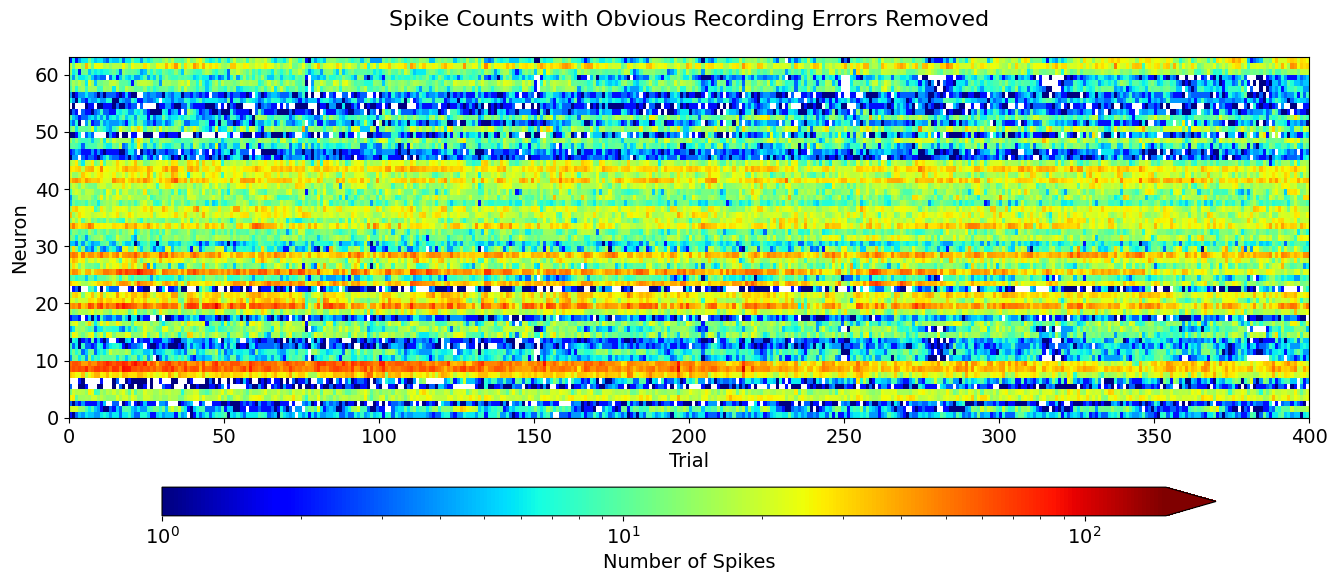

In [21]:
#visualize heatmap showing the number of spikes per trial,neuron pair
title = 'Spike Counts with Obvious Recording Errors Removed\n'
vmin=1.
vmax=150.
figsize=(16,6)
cmap='jet'
fig, ax = plt.subplots(figsize=figsize,constrained_layout=True)
ax = GridValuePlotter_colorbar(fig,ax,x,y,z,title,cmap,vmin,vmax,
        fontsize=14,xlabel='Trial',ylabel='Neuron')
plt.show()

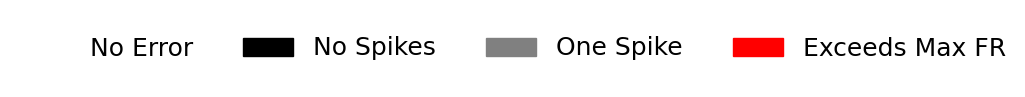

In [22]:
# define discrete color map for error codes
dict_error_labels = {0:'No Error', 1:'No Spikes', 2:'One Spike', 3:'Exceeds Max FR'}
dict_error_colors = {0:'white', 1:'black', 2:'gray', 3:'red'}
levels=list(dict_error_colors.keys())
levels.append(np.max(levels)+1)
cmap, norm = mpl.colors.from_levels_and_colors(levels=levels, 
                                               colors=list(dict_error_colors.values()), 
                                               extend='neither')
#show legend for error codes
label_lst=list(dict_error_labels.values())
color_lst=list(dict_error_colors.values())
kwargs_legend={
    'frameon':False,
    'loc':'center',
    'ncol':len(label_lst),
    'fontsize':18}
PlotLegend(label_lst=label_lst,color_lst=color_lst,**kwargs_legend);

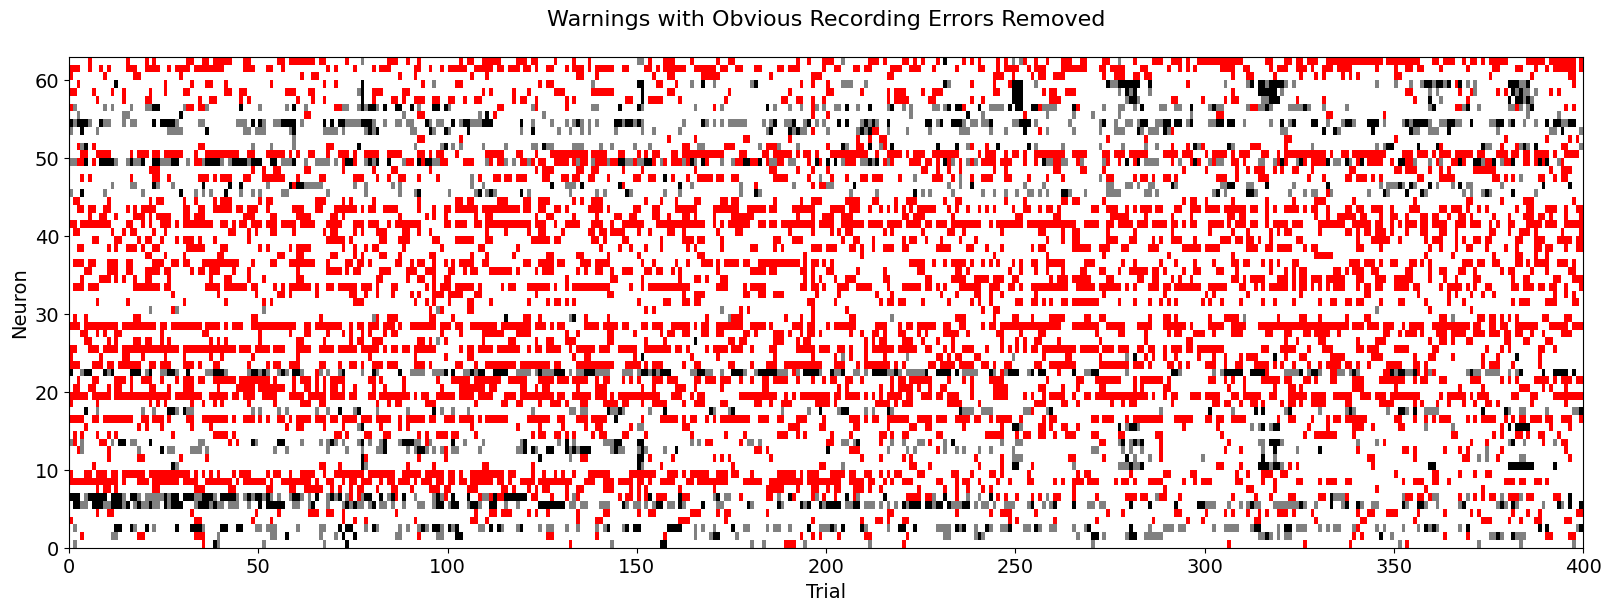

In [23]:
#visualize heatmap showing error codes of any neuron pair
title = 'Warnings with Obvious Recording Errors Removed\n'
fig, ax = plt.subplots(figsize=figsize,constrained_layout=True)
GridValuePlotter_simple(ax,x,y,zerr,title,cmap,norm,
        fontsize=14,xlabel='Trial',ylabel='Neuron')
plt.show()

# randomly split trials into train and test sets

use train_test_split_multimodal_crossval to perform the train-test split that results in the testing folds, which
- uses stratified cross-validation,
- stratifies by depicted stimulus identity, and
- is performed statistically independently on each modality.

In [24]:
n_splits=8
shuffle=True
random_state=42

#perform train test split
df_labels = train_test_split_multimodal_crossval(concept_name_values_selected,df_labels,
                                         trial_num_values_remove=trial_num_values_unreasonable,
                                         n_splits=n_splits,shuffle=shuffle,random_state=random_state)
boo=False
df_labels['cv_fold']=-1
for col in ['cv_fold_face_only', 'cv_fold_voice_only', 
            'cv_fold_match', 'cv_fold_mismatch']:
    boo_mode = df_labels[col]>-1
    df_labels.loc[boo_mode,'cv_fold']=df_labels.loc[boo_mode,col]
    boo |= boo_mode
num_trials=sum(boo)
print(f"number of trials involved in cross-validation stratified over both identity and modality: {num_trials}")
df_labels[df_labels['cv_fold']>-1].shape

number of trials involved in cross-validation stratified over both identity and modality: 277


(277, 46)

# generate time bins for an individual

## select an indivdual

In [25]:
concept_name_trgt='hermes'
task_str_trgt = f'i_{concept_name_trgt}' 
print(f"identity selected for decoding: {concept_name_trgt.capitalize()}")

identity selected for decoding: Hermes


## generate time bins for identity-specific classification

We will be using gener_tbins_fast to generate candidate time bins.

In [26]:
print (gener_tbins_fast.__doc__)

gener_tbins_fast returns a tuple of df_tbins and df_tbins_refined, respectively.
    booT,booF are boolean index arrays indexing the true/false training trials, respectively.
    spike_time_array is a 2D numpy array instance of list objects that contain spike times for a given trial-neuron pair.
    decreasing max_dur_overlap may needlessly remove useful predictive time bins,
    so its default value is set arbitrarily large while remaining small enough to be a float32 instance.
    using refinement may add ~2minutes to the estimated run time (default: refinement=True).
    otherwise, gener_tbins_fast can run in tpyically less than 2 minutes per call.

    Parameters Settings
    --------------------
        nid_values_reasonable: neuron index values to consider.  all neurons are considered if nid_values_reasonable is None (default: nid_values_reasonable=None)

        taumin: earliest start time

        taumax: latest end time

        delta_tau_min: time between two start/end times


In [27]:
#define the list of time bin search tasks
task_lst=[]
#for each cv_iteration
for cv_iter in range(n_splits):
    #identify the training trials for the fold
    boo_face_train = (df_labels['cv_fold_face_only']>-1) & (df_labels['cv_fold_face_only']!=cv_iter)
    boo_voice_train = (df_labels['cv_fold_voice_only']>-1) & (df_labels['cv_fold_voice_only']!=cv_iter)
    boo_match_train = (df_labels['cv_fold_match']>-1) & (df_labels['cv_fold_match']!=cv_iter)
    boo_mismatch_train = (df_labels['cv_fold_mismatch']>-1) & (df_labels['cv_fold_mismatch']!=cv_iter)
    #identify the training trials
    boo_xmod_train = boo_match_train.values | boo_mismatch_train.values
    boo_train = boo_xmod_train | boo_face_train.values | boo_voice_train.values
    num_xmod_train = np.sum(boo_xmod_train)
    num_train = np.sum(boo_train)
    #task for the match versus mismatch (MvMM) predictive population
    task_str='MvMM'
    #identify the boolean indices for training trials for the individual concept decoder involving the individual
    booT= ((df_labels[f'y_{task_str}']==1)&boo_xmod_train).values
    booF= ((df_labels[f'y_{task_str}']==0)&boo_xmod_train).values
    #identify the boolean indices for testing trials for the individual concept decoder involving the individual
    boo_xmod = (df_labels['y_xmod']==1) # & boo_reasonable
    boo_cv   = (df_labels['cv_fold_match']==cv_iter)|(df_labels['cv_fold_mismatch']==cv_iter)
    booT_test= ((df_labels[f'y_{task_str}']==1)&boo_xmod&boo_cv).values
    booF_test= ((df_labels[f'y_{task_str}']==0)&boo_xmod&boo_cv).values
    booT_all= booT_test | booT
    booF_all= booF_test | booF
    #MvMM task
    task=dict(spike_time_array=spike_time_array.copy(),
              booT=booT.copy(),booF=booF.copy(),nid_values_reasonable=nid_values_reasonable.copy(),
              booT_test=booT_test.copy(),booF_test=booF_test.copy(), task_str=task_str, cv_iter=int(cv_iter))
    task_lst.append(task)
    #task for each individual
    concept_label=0
    concept_label_lst=[]
    for concept_name in concept_name_values_selected:
        concept_label+=1
        #task for each identity-specific predictive population
        task_str=f'i_{concept_name}'
        #identify the boolean indices for training trials for the individual concept decoder involving the individual
        booT= ((df_labels[f'y_{task_str}']==1)&boo_train).values
        booF= ((df_labels[f'y_{task_str}']==0)&boo_train).values
        #identify the boolean indices for testing trials for the individual concept decoder involving the individual
        boo_cv_i   = (df_labels['cv_fold_face_only']==cv_iter)|(df_labels['cv_fold_voice_only']==cv_iter)
        boo_cv_ = boo_cv_i | boo_cv
        booT_test= ((df_labels[f'y_{task_str}']==1)&boo_cv_).values
        booF_test= ((df_labels[f'y_{task_str}']==0)&boo_cv_).values
        booT_all= booT_test | booT
        booF_all= booF_test | booF
        #identity-specific task
        task=dict(spike_time_array=copy.deepcopy(spike_time_array.copy()),
                  booT=booT.copy(),booF=booF.copy(),nid_values_reasonable=nid_values_reasonable.copy(),
                  booT_test=booT_test.copy(),booF_test=booF_test.copy(), 
                  booT_all=booT_all.copy(),booF_all=booF_all.copy(),
                  task_str=task_str, cv_iter=int(cv_iter))
        task_lst.append(task)

print(f"added {len(task_lst)} tasks to queue!")

added 64 tasks to queue!


In [28]:
task_lst_selected = []
task_lst_not_selected = []
for task in task_lst:
    task_str=task['task_str']
    if task_str==task_str_trgt:
        task_lst_selected.append(task)
    else:
        task_lst_not_selected.append(task)

def routine(task):
    df_tbins,df_tbins_refined = gener_tbins_fast(
            refinement=True,
            num_cv_samples=5,
            mode='mean', printing=False,**task)
    task.pop('spike_time_array')
    dict_out=dict(df_tbins=df_tbins,df_tbins_refined=df_tbins_refined,task=task)
    return dict_out

print(f"selected {len(task_lst_selected)} tasks from queue!") 

selected 8 tasks from queue!


In [29]:
use_generate_time_bins=True
# use_generate_time_bins=False
npartitions = np.max((1,os.cpu_count()))
npartitions = np.min((npartitions,len(task_lst_selected)))
if use_generate_time_bins:
    print(f"evaluating {len(task_lst_selected)} calls to gener_tbins_fast over {npartitions} cpu cores...")
    print(f"\t- (my run time was ~16 minutes for recognizing hades recognizing hermes on 8 cpu cores...)")
    print(f"\t- (the math doesn't make sense... at 2 minutes per call, it should take 2*16/8=4 minutes to evaluate... hmm...)")
    retval = eval_routine_daskbag(routine,task_lst_selected,npartitions,printing=True)

evaluating 8 calls to gener_tbins_fast over 8 cpu cores...
	- (my run time was ~16 minutes for recognizing hades recognizing hermes on 8 cpu cores...)
	- (the math doesn't make sense... at 2 minutes per call, it should take 2*16/8=4 minutes to evaluate... hmm...)
run time for evaluating routine was 611.59 seconds, yielding 8 values returned


In [30]:
if use_generate_time_bins:
    #always save your parameter settings
    settings_gener_tbins=dict(min_num_appearances=min_num_appearances,
                     min_num_match=min_num_match,
                     max_block_size=max_block_size,
                     min_refractory_period=min_refractory_period,
                     max_count_err_3_by_trial=max_count_err_3_by_trial,
                     max_count_err_3_by_neuron=max_count_err_3_by_neuron,
                     n_splits=n_splits,
                     random_state=random_state)
    print_dict(settings_gener_tbins)
    # save tbins to .json
    dict_tbins_lst=retval
    print(f"saving all candidate time bins (estimated run time ~?? minutes)...")
    dict_tbins_set=dict(session_num=session_num,dict_tbins_lst=dict_tbins_lst,
                       df_labels=df_labels,
                       dict_transcript= data['dict_transcript'],
                      settings_gener_tbins=settings_gener_tbins)
    tbin_set_dir = data_dir.replace('.json',f'_tbin_set_{task_str_trgt}.json')
    save_dict_to_json_converted(dict_tbins_set,tbin_set_dir)
    print(f"{tbin_set_dir=}")

min_num_appearances=40
min_num_match=3
max_block_size=20
min_refractory_period=0.006666666666666667
max_count_err_3_by_trial=75
max_count_err_3_by_neuron=300
n_splits=8
random_state=42
saving all candidate time bins (estimated run time ~?? minutes)...
tbin_set_dir='/Users/timothytyree/Documents/TyreeEtAl_data/data_tbin_set_i_hermes.json'


In [31]:
beep(1)

-n 


0

# identify neurons with tbins that appear to predict the face or voice of the selected individual

__A stratified cross-validation within a stratified cross-validation.__

Time bins with $p<0.05$ appear predictive, where $p$ is the mean p-value that results from a Wilcox-Mann-Whitney test conducted over the training training trials of each training fold resulting from `num_cv_samples`=5-fold stratified cross validation of the training trials accessed by a given call to `gener_tbins_fast`.  The training trials were determined by 
`n_splits`=8-fold stratified cross-vaildation of all trials considered using `train_test_split_multimodal_crossval`.

In [32]:
use_cache=True
if use_cache:
    #load tbins from cache
    #tbin_set_dir='/Users/timothytyree/Documents/TyreeEtAl_data/data_tbin_set_i_hermes.json'
    dict_tbins_set=load_from_json(tbin_set_dir)
    print(f"loaded tbins from cache: {tbin_set_dir=}")

loaded tbins from cache: tbin_set_dir='/Users/timothytyree/Documents/TyreeEtAl_data/data_tbin_set_i_hermes.json'


In [33]:
df_neurons = pd.DataFrame(data['dict_etc']['df_neurons'])
t_values = np.array(data['dict_etc']['dict_spike_templates']['t_values'])
dict_spike_template_lst = data['dict_etc']['dict_spike_templates']['dict_spike_template_lst']
df_neurons = comp_waveform_properties(df_neurons,dict_spike_template_lst,t_values)
assert not df_neurons['dVpp'].isnull().any()
df_neurons.head()

,session_num,num_tbins,concept_cell,concept_name,GlobalIndex,AP_pos,num_trials_anomalously_low_fr,frac_trials_anomalously_low_fr,dVpp,fwhm
nid,,,,,,,,,,
0,13,1,0,NaN,613,NaN,0,0.000000,30.071036,0.100000
1,13,1,0,NaN,614,NaN,0,0.000000,28.989810,0.100000
2,13,0,0,NaN,615,NaN,0,0.000000,9.007807,0.133333
3,13,1,0,NaN,616,NaN,11,0.024336,10.589106,0.233333
4,13,0,0,NaN,617,NaN,43,0.095133,4.356375,0.133333


In [34]:
p_significant=0.05
print(f"selecting all tbins with p<0.05...")
#identify which neurons appear predictive before doing any sort of reasonable filtering
df_pred_tbins_lst = extract_pred_tbin_list_detailed(dict_tbins_set, df_neurons, df_es, count_err_3_by_neuron, spike_time_array,
            p_significant=p_significant,printing=True,
            use_reasonable_filtering=False)
df_pred_tbins_agg_raw=pd.concat(df_pred_tbins_lst).reset_index()
df_pred_tbins_agg_raw['duration']=df_pred_tbins_agg_raw['tau2'] - df_pred_tbins_agg_raw['tau1']
assert not df_pred_tbins_agg_raw['dVpp'].isnull().any()
#take union of neuron index over cross-validation folds before/after filtering
nid_values_pred_raw = np.sort(df_pred_tbins_agg_raw['nid'].drop_duplicates().values)
print(f"number of neurons that appear predictive in any test fold: {nid_values_pred_raw.shape[0]} (raw)")
print(f"number of tbins overall: {df_pred_tbins_agg_raw.shape[0]} (raw)")

selecting all tbins with p<0.05...
extracting descriptive properties of predictive time bins...
			overall AUC: 			min,	   25%,	   median,	 75%,	     max,
i_hermes (cv_iter: 0):	  num pred neurons: 39, [0.55361757 0.59101073 0.61270125 0.63737329 0.68758696]
i_hermes (cv_iter: 1):	  num pred neurons: 32, [0.56668654 0.60359521 0.62209302 0.64131137 0.69345061]
i_hermes (cv_iter: 2):	  num pred neurons: 29, [0.57245081 0.60002982 0.61036573 0.63873981 0.69345061]
i_hermes (cv_iter: 3):	  num pred neurons: 39, [0.55485987 0.60350825 0.61826675 0.63821805 0.69345061]
i_hermes (cv_iter: 4):	  num pred neurons: 39, [0.54879746 0.59332141 0.60937189 0.63585768 0.69345061]
i_hermes (cv_iter: 5):	  num pred neurons: 43, [0.57930829 0.59679984 0.61185649 0.63821805 0.69345061]
i_hermes (cv_iter: 6):	  num pred neurons: 41, [0.58507255 0.60375671 0.62189426 0.63873981 0.69345061]
i_hermes (cv_iter: 7):	  num pred neurons: 38, [0.56231366 0.58906033 0.61066388 0.63129845 0.69345061]
number of neu

## make scatter plot visualizing reasonable tbin filtering

In [35]:
#parameters for reasonable filtering
max_frac_trials_anomalously_low_fr=0.3
max_frac_trials_anomalously_high_fr=0.55
max_dVpp=13.5 #mV 
max_fwhm=10. #ms
max_final_err_1_streak=1
max_training_p_aggregated=1. 
frac_drop_training_auc=0.6

In [36]:
#generate boolean index of reasonable filtering for tbins
boo_low_fr,boo_high_fr,boo_dVpp,boo_fwhm,boo_fstreak,boo_pagg,boo_low_training_auc = gener_tbin_filter(
                      df_tbins = df_pred_tbins_agg_raw,
                      max_frac_trials_anomalously_low_fr=max_frac_trials_anomalously_low_fr,
                      max_dVpp=max_dVpp,  #mV
                      max_fwhm=max_fwhm,  #ms
                      max_frac_trials_anomalously_high_fr=max_frac_trials_anomalously_high_fr,
                      max_final_err_1_streak=max_final_err_1_streak,
                      max_training_p_aggregated=max_training_p_aggregated,
                      frac_drop_training_auc=frac_drop_training_auc,
                      min_training_auc=None)                                                                           

# boo_fwhm = df_pred_tbins_agg_raw['fwhm']>max_fwhm
print(f"num pred tbins that trigger:")
print(f"aggregated {df_pred_tbins_agg_raw.shape[0]} predictive time bins across {n_splits} testing folds:")
print(f"  - num pred tbins with high firing rate warning: {sum(boo_high_fr)}")
print(f"  - num pred tbins with low firing rate warning: {sum(boo_low_fr)}")
print(f"  - num pred tbins with high firing amplitude warning: {sum(boo_dVpp)}")
print(f"  - num pred tbins with high full width half max: {sum(boo_fwhm)}")
print(f"  - num pred tbins with final streak warning: {sum(boo_fstreak)}")
print(f"  - num pred tbins with low training auc warning: {sum(boo_low_training_auc)}")

#compute boolean index for tbins that trigger warnings
boo_filter =  boo_low_fr|boo_high_fr|boo_fstreak|boo_pagg|boo_low_training_auc|boo_dVpp|boo_fwhm
sum (~boo_filter)

num pred tbins that trigger:
aggregated 300 predictive time bins across 8 testing folds:
  - num pred tbins with high firing rate warning: 28
  - num pred tbins with low firing rate warning: 0
  - num pred tbins with high firing amplitude warning: 40
  - num pred tbins with high full width half max: 0
  - num pred tbins with final streak warning: 92
  - num pred tbins with low training auc warning: 180


87

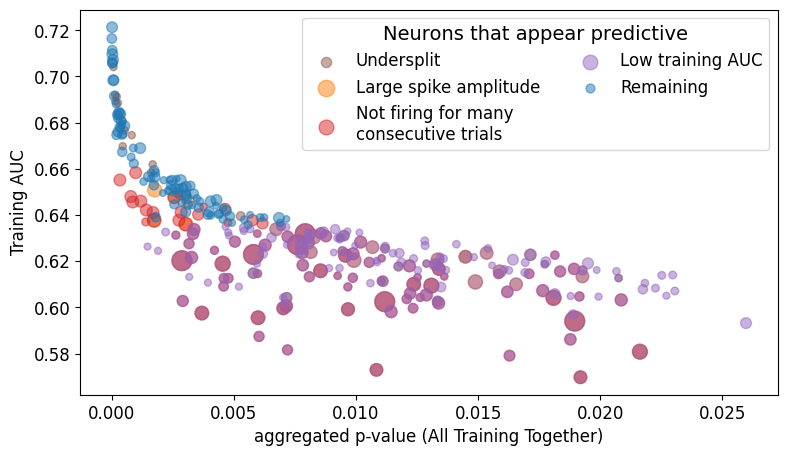

In [37]:
#scatter plot of predictive time bins
fontsize=12
alpha=0.5
xcol='p'
xlabel='p'
xcol='p_aggregated'
xlabel='aggregated p-value (All Training Together)'
ycol='auc_train'
ylabel='Training AUC'
# ycol='auc_overall'
# ylabel='AUC'

#column scol determines markersize 
scol='dVpp'
# scol='fwhm'
# scol='duration'
# # scol='err_3_count'
# scol='longest_err_1_streak'
# # scol='final_err_1_streak'
# scol='frac_trials_anomalously_low_fr'
# scol='frac_trials_anomalously_high_fr'
# scol='max_spike_count'

df_pred_tbins_agg_raw['markersize']=2e2*df_pred_tbins_agg_raw[scol]/np.max(df_pred_tbins_agg_raw[scol])+1
scol='markersize'
fig,ax=plt.subplots(figsize=(9,5))
df_pred_tbins_agg_raw[boo_high_fr].plot.scatter(x=xcol,y=ycol,alpha=alpha,s=scol,c='C5',ax=ax,label=f'Undersplit')
# df_pred_tbins_agg_raw[boo_low_fr].plot.scatter(x=xcol,y=ycol,alpha=alpha,s=scol,c='C2',ax=ax,label='Oversplit')
df_pred_tbins_agg_raw[boo_dVpp].plot.scatter(x=xcol,y=ycol,alpha=alpha,s=scol,c='C1',ax=ax,label=r'Large spike amplitude')
# df_pred_tbins_agg_raw[boo_fwhm].plot.scatter(x=xcol,y=ycol,alpha=alpha,s=scol,c='k',ax=ax,label=f'FWHM>{max_fwhm}')
df_pred_tbins_agg_raw[boo_fstreak].plot.scatter(x=xcol,y=ycol,alpha=alpha,s=scol,c='C3',ax=ax,label='Not firing for many\nconsecutive trials')
# df_pred_tbins_agg_raw[boo_pagg].plot.scatter(x=xcol,y=ycol,alpha=alpha,s=scol,c='gray',ax=ax,label='High aggregated p-value')
df_pred_tbins_agg_raw[boo_low_training_auc].plot.scatter(x=xcol,y=ycol,alpha=alpha,s=scol,c='C4',ax=ax,label='Low training AUC')
df_pred_tbins_agg_raw[~boo_filter].plot.scatter(x=xcol,y=ycol,alpha=alpha,s=scol,c='C0',ax=ax,label='Remaining')
ax.legend(fontsize=fontsize,loc='upper right',ncol=2,#loc=(1.04,0.4),ncol=1,#
          title='Neurons that appear predictive',title_fontsize=fontsize+2)
format_plot(xlabel=xlabel,ylabel=ylabel,fontsize=fontsize)
plt.show()

In [38]:
#identify predictive time bins that are unreasonable independently for each fold
#   (e.g. low firing rate, amplitude too high, training auc low, etc...)
df_pred_tbins_lst = extract_pred_tbin_list_detailed(dict_tbins_set, df_neurons, 
                df_es, count_err_3_by_neuron, spike_time_array,
                p_significant=p_significant,printing=True,
                use_reasonable_filtering=True,
                max_frac_trials_anomalously_low_fr=max_frac_trials_anomalously_low_fr,
                max_frac_trials_anomalously_high_fr=max_frac_trials_anomalously_high_fr,
                max_dVpp=max_dVpp, #mV
                max_fwhm=max_fwhm, #ms
                max_final_err_1_streak=max_final_err_1_streak,
                max_training_p_aggregated=max_training_p_aggregated,
                frac_drop_training_auc=frac_drop_training_auc,
                min_training_auc=None)    
df_pred_tbins_agg=pd.concat(df_pred_tbins_lst).reset_index()

#take union of neuron index over cross-validation folds before/after filtering
nid_values_pred_raw = np.sort(df_pred_tbins_agg_raw['nid'].drop_duplicates().values)
nid_values_pred_filtered = np.sort(df_pred_tbins_agg['nid'].drop_duplicates().values)
print(f"number of neurons that appear predictive in any fold: {nid_values_pred_raw.shape[0]} (raw)")
print(f"number of neurons that appear predictive in any fold: {nid_values_pred_filtered.shape[0]} (filtered)")

#test all folds still have tbins
for df_pred_tbins in df_pred_tbins_lst:
    assert df_pred_tbins.shape[0]>0

extracting descriptive properties of predictive time bins...
			overall AUC: 			min,	   25%,	   median,	 75%,	     max,
i_hermes (cv_iter: 0):	  num pred neurons: 39, [0.55361757 0.59101073 0.61270125 0.63737329 0.68758696]
i_hermes (cv_iter: 0):	  num pred neurons: 13, [0.5976446  0.63769628 0.64316239 0.67153647 0.68758696] (filtered)
i_hermes (cv_iter: 1):	  num pred neurons: 32, [0.56668654 0.60359521 0.62209302 0.64131137 0.69345061]
i_hermes (cv_iter: 1):	  num pred neurons: 11, [0.62830451 0.63873981 0.65464122 0.67824488 0.69345061] (filtered)
i_hermes (cv_iter: 2):	  num pred neurons: 29, [0.57245081 0.60002982 0.61036573 0.63873981 0.69345061]
i_hermes (cv_iter: 2):	  num pred neurons: 8, [0.63531107 0.6445165  0.65672828 0.67489068 0.69345061] (filtered)
i_hermes (cv_iter: 3):	  num pred neurons: 39, [0.55485987 0.60350825 0.61826675 0.63821805 0.69345061]
i_hermes (cv_iter: 3):	  num pred neurons: 13, [0.61826675 0.63401908 0.63978334 0.67153647 0.69345061] (filtered)
i_her

## visualize spike shape with spike sorting templates of neurons that appear to predict the face or voice of the selected individual

In [39]:
t_values = np.array(data['dict_etc']['dict_spike_templates']['t_values'])
dict_spike_template_lst = data['dict_etc']['dict_spike_templates']['dict_spike_template_lst']

#identify set of neurons with and without filtering
pred_nid_values_agg_raw=np.unique(df_pred_tbins_agg_raw['nid'].values)
pred_nid_values_agg=np.unique(df_pred_tbins_agg['nid'].values)

In [40]:
#extract spike sorting templates from dict_spike_template_lst
dict_spike_template_lst_agg_raw=[]
dict_spike_template_lst_agg=[]
for dict_spike_template in dict_spike_template_lst:
    nid=dict_spike_template['nid']
    if (nid==pred_nid_values_agg_raw).any():
        dict_spike_template_lst_agg_raw.append(dict_spike_template)
    if (nid==pred_nid_values_agg).any():
        dict_spike_template_lst_agg.append(dict_spike_template)

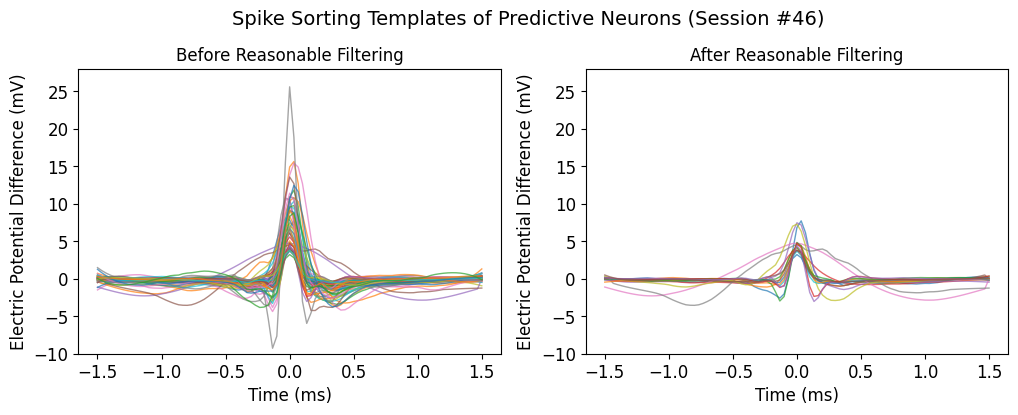

In [41]:
#visualize spike time triggered averages of neurons that appear to predict the face or voice of the selected individual
fontsize=14
alpha=0.7
lw=1
fontsize=12
ylim=[-10,28]
fig,axs=plt.subplots(ncols=2,figsize=(12,3.7))
#plot the final template waveform before filtering pred tbins
ax=axs[0]
max_dVpp_raw=0
for dict_spike_template in dict_spike_template_lst_agg_raw:
    waveform = dict_spike_template['waveform']
    #compute peak to peak voltage difference
    dVpp=np.max(waveform) - np.min(waveform)
    if max_dVpp_raw<dVpp:
        max_dVpp_raw=dVpp    
    #plot waveform
    ax.plot(t_values,waveform, alpha=alpha, lw=lw)
#format_plot
format_plot(ax=ax,xlabel="Time (ms)", ylabel="Electric Potential Difference (mV)",fontsize=fontsize)
ax.set_title('Before Reasonable Filtering',fontsize=fontsize)
ax.set_ylim(ylim)

#plot the final template waveform after filtering pred tbins
ax=axs[1]
max_dVpp=0
fwhm_lst=[]
for dict_spike_template in dict_spike_template_lst_agg:
    waveform = dict_spike_template['waveform']
    #compute peak to peak voltage difference
    dVpp=np.max(waveform) - np.min(waveform)
    if max_dVpp<dVpp:
        max_dVpp=dVpp    
    #plot waveform
    ax.plot(t_values,waveform, alpha=alpha, lw=lw)

#format_plot
format_plot(ax=ax,xlabel="Time (ms)", ylabel="Electric Potential Difference (mV)",fontsize=fontsize)
ax.set_ylim(ylim)
ax.set_title('After Reasonable Filtering',fontsize=fontsize)

#set the title
title=f"Spike Sorting Templates of Predictive Neurons (Session #{session_num+1})"
fig.suptitle(title,fontsize=fontsize+2,y=1.04)
plt.show()

templates with large full-width half max appeared to be more predictive then the average tbin remaining in some recording sessions.

## visualize heat maps of neurons/trials to be decoded

In [42]:
trial_num_values_involved= df_labels.loc[df_labels['cv_fold']>-1,'trial_num'].values
spike_count_array_ = spike_count_array[trial_num_values_involved] 
error_code_array_ = error_code_array[trial_num_values_involved] 

In [43]:
show_raw=True
show_raw=False
if show_raw:
    pred_nid_values=np.unique(df_pred_tbins_agg_raw['nid'].values)
else:
    pred_nid_values=np.unique(df_pred_tbins_agg['nid'].values)

#generate xy coordinate grids
num_trials,_ = error_code_array_.shape
num_neurons = len(pred_nid_values)
xcoord_values = np.arange(num_trials+1)  #as corners of pixels
ycoord_values = np.arange(num_neurons+1) #as corners of pixels
x, y = np.meshgrid(xcoord_values, ycoord_values)
y=y[::-1,::-1].copy() #flip y axis
x=x.copy()
z=spike_count_array_.copy().T[pred_nid_values]
zerr=error_code_array_.copy().T[pred_nid_values]

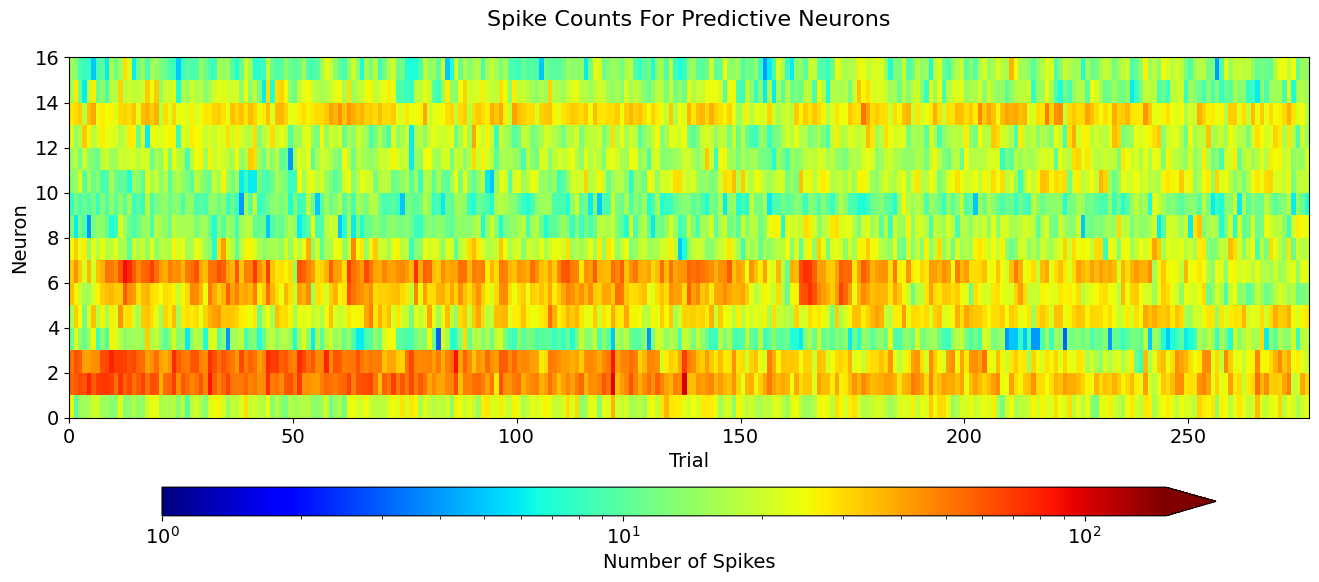

In [44]:
#visualize the heatmap constrained to predictive neurons
title = 'Spike Counts For Predictive Neurons\n'
vmin=1
vmax=150.
fontsize=14
figsize=(16,6)
cmap='jet'
fig, ax = plt.subplots(figsize=figsize,constrained_layout=True)
ax = GridValuePlotter_colorbar(fig,ax,x,y,z,title,cmap,vmin,vmax,
        fontsize=14,xlabel='Trial',ylabel='Neuron')
plt.show()

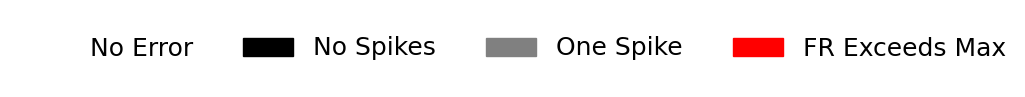

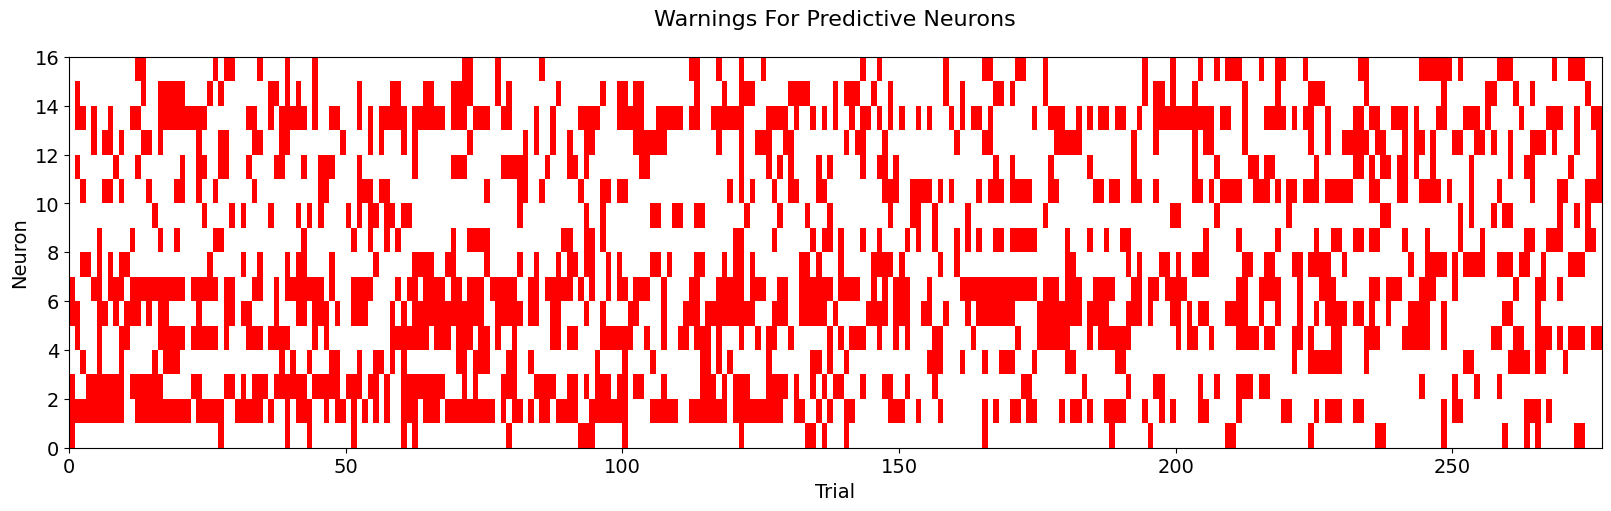

In [45]:
#plot any obvious recording errors
# define discrete color map for error codes
dict_error_labels = {0:'No Error', 1:'No Spikes', 2:'One Spike', 3:'FR Exceeds Max'}
dict_error_colors = {0:'white', 1:'black', 2:'gray', 3:'red'}
levels=list(dict_error_colors.keys())
levels.append(np.max(levels)+1)
cmap, norm = mpl.colors.from_levels_and_colors(levels=levels, colors=list(dict_error_colors.values()), extend='neither')

#make a separate legend for error codes
label_lst=list(dict_error_labels.values())
color_lst=list(dict_error_colors.values())
kwargs_legend={
    'frameon':False,
    'loc':'center',
    'ncol':len(label_lst),
    'fontsize':18,
}
PlotLegend(label_lst=label_lst,color_lst=color_lst,figsize=(1,1),**kwargs_legend);
plt.show()

#visualize heatmap showing error codes of any neuron pair
title = 'Warnings For Predictive Neurons\n'
fontsize=14
figsize=(16,5)
fig, ax = plt.subplots(figsize=figsize,constrained_layout=True)
GridValuePlotter_simple(ax,x,y,zerr,title,cmap,norm,
        fontsize=fontsize,xlabel='Trial',ylabel='Neuron')
plt.show()

# generate predictions face or voice of selected individual

In [46]:
#test that there was zero overlap between all test and train trials
dict_tbins_lst = dict_tbins_set['dict_tbins_lst']
for dict_tbins in dict_tbins_lst: # for each fold,
    task_str = dict_tbins['task']['task_str']
    cv_iter  = dict_tbins['task']['cv_iter']
    booT = np.array(dict_tbins['task']['booT'])
    booF = np.array(dict_tbins['task']['booF'])
    booT_test = np.array(dict_tbins['task']['booT_test'])
    booF_test = np.array(dict_tbins['task']['booF_test'])
    #test unit for disjointness of true/false test/train trials.
    assert not booT_test[booT].any()
    assert not booF_test[booF].any()
    assert not booT[booT_test].any()
    assert not booF[booF_test].any()
    assert not booT_test[booF_test].any()
    assert not booF_test[booT_test].any()
    assert not booT[booF].any()
    assert not booF[booT].any()
print(f"All Test Cases Passed - This proves training trials are disjoint with testing trials in every cross-validation fold.")

All Test Cases Passed - This proves training trials are disjoint with testing trials in every cross-validation fold.


In [47]:
#caste predictive tbins into same type as dict_tbins_set
dict_pred_tbins_lst=[]
for df_pred_tbins,dict_tbins in zip(df_pred_tbins_lst,dict_tbins_set['dict_tbins_lst']):
    assert df_pred_tbins.shape[0]>0
    dict_pred_tbins=dict(dict_tbins)
    dict_pred_tbins['df_tbins_refined_unfiltered'] = pd.DataFrame(dict_pred_tbins.pop('df_tbins_refined'))
    dict_pred_tbins['df_tbins_refined'] = df_pred_tbins.copy()
    dict_pred_tbins_lst.append(dict_pred_tbins)

## generate predictions for a single fold directly

In [48]:
#select trials and features from a fold
dict_tbins = dict_pred_tbins_lst[1]
X,tbin_indices=extract_simple_firing_rates(spike_time_array, dict_tbins['df_tbins_refined'])
task_str = dict_tbins['task']['task_str']
cv_iter  = dict_tbins['task']['cv_iter']
booT = np.array(dict_tbins['task']['booT'])
booF = np.array(dict_tbins['task']['booF'])
booT_test = np.array(dict_tbins['task']['booT_test'])
booF_test = np.array(dict_tbins['task']['booF_test'])
boo_train = booT|booF
boo_test  = booT_test|booF_test
#test unit for disjointness of true/false test/train trials.
assert not booT_test[booT].any()
assert not booF_test[booF].any()
assert not booT[booT_test].any()
assert not booF[booF_test].any()
assert not booT_test[booF_test].any()
assert not booF_test[booT_test].any()
assert not booT[booF].any()
assert not booF[booT].any()
#test shapes all agree
num_trials = X.shape[0]
assert num_trials == booT.shape[0]
assert num_trials == booF.shape[0]
assert num_trials == booT_test.shape[0]
assert num_trials == booF_test.shape[0]
#recall trial labels
y = df_labels[f"y_{task_str}"].values

In [49]:
#format labeled features as the canonical machine learning kwargs
xtrain = X[boo_train]
ytrain = y[boo_train]
xtest = X[boo_test]
ytest = y[boo_test]
#test labels cover the same space
assert (np.unique(ytest)==np.unique(ytrain)).all()

In [50]:
#parse decoder arguments
kwargs_decoder = parse_decoder_kwargs(data['dict_decoder_hyperparameters'],
                                      task_index=1,# 0: MvMM, 1: identity-specific
                                      gpu_available=False,
                                      scale_pos_weight = 5.,#sum(booF)/sum(booT),
                                      learning_rate = 0.1)
print_dict(kwargs_decoder)
# nota bene: scale_pos_weight = num_F_trials/num_T_trials should work in most contexts

objective=binary:logistic
scale_pos_weight=5.0
learning_rate=0.1
base_score=0.5
num_parallel_tree=50
subsample=0.2
colsample_bynode=0.1
max_depth=2
min_child_weight=1
max_delta_step=1
gamma=5
reg_alpha=0.3
reg_lambda=0.3
tree_method=hist
eval_metric=auc
single_precision_histogram=True
random_state=42
n_jobs=7


In [51]:
#define the model
clf = XGBClassifier(n_estimators=60,use_label_encoder=False,**kwargs_decoder)

#fit the model
# eval_set=[(xtrain, ytrain)]
eval_set=[(xtrain, ytrain), (xtest, ytest)]
clf.fit(xtrain, ytrain, eval_set=eval_set,verbose=1)

#predict from the model
probas = clf.predict_proba(xtest)[:,1]
num_features = xtest.shape[1]
dict_cm,dict_decoder = test_decoder_predictions(probas,ytest,num_features=num_features)

[0]	validation_0-auc:0.86008	validation_1-auc:0.89655
[1]	validation_0-auc:0.87818	validation_1-auc:0.89655
[2]	validation_0-auc:0.88614	validation_1-auc:0.84138
[3]	validation_0-auc:0.89743	validation_1-auc:0.86207
[4]	validation_0-auc:0.89974	validation_1-auc:0.89655
[5]	validation_0-auc:0.89987	validation_1-auc:0.89655
[6]	validation_0-auc:0.89885	validation_1-auc:0.93103
[7]	validation_0-auc:0.90462	validation_1-auc:0.94483
[8]	validation_0-auc:0.90616	validation_1-auc:0.92414
[9]	validation_0-auc:0.90629	validation_1-auc:0.92414
[10]	validation_0-auc:0.90449	validation_1-auc:0.93103
[11]	validation_0-auc:0.90270	validation_1-auc:0.93103
[12]	validation_0-auc:0.90565	validation_1-auc:0.91724
[13]	validation_0-auc:0.90462	validation_1-auc:0.91724
[14]	validation_0-auc:0.90436	validation_1-auc:0.91724
[15]	validation_0-auc:0.90950	validation_1-auc:0.91724
[16]	validation_0-auc:0.91065	validation_1-auc:0.92414
[17]	validation_0-auc:0.91143	validation_1-auc:0.90345
[18]	validation_0-au

## generate predictions for all folds

In [52]:
dict_results = routine_generate_decoder_predictions_test(dict_pred_tbins_lst,spike_time_array,data,df_labels,
                        p_significant=0.05,
                        scale_pos_weight=5,
                        learning_rate=0.1, 
                        n_epochs=60,
                        gpu_available=False,
                        return_clf=False,
                        test_selected_only=True, #False, # False includes remaining trials              
                        printing=True,verbose=0)
df_results = dict_results['df_results']

dict_results['session_num']=session_num
dict_results['df_labels']=df_labels.copy()
df_results = dict_results['df_results']
mean_auc = df_results['auc'].mean()
mean_num_features = df_results['num_features'].mean()
print(f"tested with {mean_num_features=:.4f} for session #{session_num}: mean AUC: {mean_auc:.4f}")

predictive population for i_hermes: mean overall auc =	0.6496 +/- 0.0257 (N_pred_tbins=13) ==> AUC=0.6488
predictive population for i_hermes: mean overall auc =	0.6580 +/- 0.0220 (N_pred_tbins=11) ==> AUC=0.9517
predictive population for i_hermes: mean overall auc =	0.6605 +/- 0.0198 (N_pred_tbins=8) ==> AUC=0.7381
predictive population for i_hermes: mean overall auc =	0.6504 +/- 0.0245 (N_pred_tbins=13) ==> AUC=0.8495
predictive population for i_hermes: mean overall auc =	0.6481 +/- 0.0265 (N_pred_tbins=14) ==> AUC=0.7619
predictive population for i_hermes: mean overall auc =	0.6471 +/- 0.0301 (N_pred_tbins=15) ==> AUC=0.5665
predictive population for i_hermes: mean overall auc =	0.6502 +/- 0.0240 (N_pred_tbins=14) ==> AUC=0.5625
predictive population for i_hermes: mean overall auc =	0.6493 +/- 0.0275 (N_pred_tbins=12) ==> AUC=0.7874
tested with mean_num_features=12.5000 for session #45: mean AUC: 0.7333


# evaluate ability to predict the face or voice of the selected individual

In [53]:
#format predictions into DataFrame
d_predictions = df_labels.copy()
rescale_predictors_to_unity=False
use_quadratic_norm=True
# rescale_predictors_to_unity=True
# use_quadratic_norm=False
print_by_ground_truth=True
print_by_mode=True
dict_roc_lst=[]
#preallocate memory to hold predictions 
count=0
for col in list(d_predictions.columns):
    if col.find('y_')==0:
        d_predictions[col.replace('y_','yhat_')]=np.nan
        count+=1
print(f"initialized {count} prediction fields in d_predictions.")
print(f"aggregating predictions over {n_splits} cross-validation folds...")
dict_decoder_lst = dict_results['dict_decoder_lst']
for df_tbins,dict_tbins,dict_decoder in zip(df_pred_tbins_lst,dict_tbins_set['dict_tbins_lst'],dict_decoder_lst):
    cv_iter=dict_tbins['task']['cv_iter']
    task_str=dict_tbins['task']['task_str']
    y_str = 'y_'+task_str
    yhat_str = 'yhat_'+task_str
    preamble=f"{task_str} (cv_iter: {cv_iter}):\t"
    booT = np.array(dict_tbins['task']['booT'])
    booF = np.array(dict_tbins['task']['booF'])
    booT_test = np.array(dict_tbins['task']['booT_test'])
    booF_test = np.array(dict_tbins['task']['booF_test'])
    assert not booT_test[booF_test].any()
    assert not booF_test[booT_test].any()
    assert not booT_test[booT].any()
    assert not booF_test[booF].any()
    
    boo_test= booT_test | booF_test
    probas = dict_decoder['probas']
    ytest = dict_decoder['ytest']
    if rescale_predictors_to_unity:
        probas/=np.max(probas)
    elif use_quadratic_norm:
        #optionally aggregate predictions to be comparable using the quadratic norm
        predictor_values=probas.copy()
        label_values=ytest.copy()
        fpr, tpr, thresholds = metrics.roc_curve(label_values, predictor_values)
        auc = metrics.auc(fpr, tpr)
        index_ideal_thresh=np.argmax(tpr*(1-fpr))
        ideal_threshold = thresholds[index_ideal_thresh]
        predictor_value_normed=norm_predictor_quadratic(predictor_values,ideal_threshold)
        fpr, tpr, thresholds = metrics.roc_curve(label_values, predictor_value_normed)
        auc_normed = metrics.auc(fpr, tpr)
        print(f"quadratic predictor norm mapped AUC: {auc:.6f} --> {auc_normed:.6f}")
        auc=float(auc_normed)
        probas=predictor_value_normed.copy()
    d_predictions.loc[boo_test,yhat_str] = probas
    
    #test the labels match the ground truth
    assert (d_predictions.loc[boo_test,y_str]==ytest).all()
    #compute the roc curve for this decoder instance
    dict_roc=comp_roc_simple(label_values=ytest, predictor_values=probas)
    auc = dict_roc['auc']
    dict_roc['args']=dict(label_values=ytest.copy(), predictor_values=probas.copy())
    if print_by_mode:
        #count the trials by mode
        d_l = df_labels[boo_test]
        boo_face_only = d_l['pheeName']=='none'
        boo_voice_only = d_l['faceName']=='none'
        boo_xmod = (~boo_face_only)&(~boo_voice_only)
        boo_match = boo_xmod & (d_l['faceName']==d_l['pheeName'])
        boo_mismatch = boo_xmod & (d_l['faceName']!=d_l['pheeName'])
        dict_trial_count_mode={
            'face':sum(boo_face_only),
            'voice':sum(boo_voice_only),
            'match':sum(boo_match),
            'mismatch':sum(boo_mismatch),
        }
        #print summary
        print(preamble+f"num pred neurons: {df_pred_tbins.shape[0]}, testing AUC: {auc:.4f}")
        #count the trials by mode
        d_l = df_labels[booT_test]
        boo_face_only = d_l['pheeName']=='none'
        boo_voice_only = d_l['faceName']=='none'
        boo_xmod = (~boo_face_only)&(~boo_voice_only)
        boo_match = boo_xmod & (d_l['faceName']==d_l['pheeName'])
        boo_mismatch = boo_xmod & (d_l['faceName']!=d_l['pheeName'])
        dict_trial_countT_mode={
            'face':sum(boo_face_only),
            'voice':sum(boo_voice_only),
            'match':sum(boo_match),
            'mismatch':sum(boo_mismatch),
        }
        #count the trials by mode
        d_l = df_labels[booF_test]
        boo_face_only = d_l['pheeName']=='none'
        boo_voice_only = d_l['faceName']=='none'
        boo_xmod = (~boo_face_only)&(~boo_voice_only)
        boo_match = boo_xmod & (d_l['faceName']==d_l['pheeName'])
        boo_mismatch = boo_xmod & (d_l['faceName']!=d_l['pheeName'])
        dict_trial_countF_mode={
            'face':sum(boo_face_only),
            'voice':sum(boo_voice_only),
            'match':sum(boo_match),
            'mismatch':sum(boo_mismatch),
        }
        print_by_ground_truth=True
        if print_by_ground_truth:
            conceptName = y_str.split('_')[-1].capitalize()
            print(f"\t\t\tcount of true test trials by mode: {dict_trial_countT_mode}")
            print(f"\t\t\tcount of false test trials by mode: {dict_trial_countF_mode}")
            print(f"\t\t\tcount of {conceptName}'s' face appearancing in test: {sum(boo_face_only)}")
            print(f"\t\t\tcount of {conceptName}'s' voice appearancing in test: {sum(boo_voice_only)}")
    #record
    dict_roc_lst.append(dict_roc)

initialized 36 prediction fields in d_predictions.
aggregating predictions over 8 cross-validation folds...
quadratic predictor norm mapped AUC: 0.648810 --> 0.648810
i_hermes (cv_iter: 0):	num pred neurons: 12, testing AUC: 0.6488
			count of true test trials by mode: {'face': 3, 'voice': 0, 'match': 1, 'mismatch': 2}
			count of false test trials by mode: {'face': 10, 'voice': 6, 'match': 6, 'mismatch': 6}
			count of Hermes's' face appearancing in test: 10
			count of Hermes's' voice appearancing in test: 6
quadratic predictor norm mapped AUC: 0.951724 --> 0.951724
i_hermes (cv_iter: 1):	num pred neurons: 12, testing AUC: 0.9517
			count of true test trials by mode: {'face': 3, 'voice': 1, 'match': 1, 'mismatch': 0}
			count of false test trials by mode: {'face': 10, 'voice': 5, 'match': 6, 'mismatch': 8}
			count of Hermes's' face appearancing in test: 10
			count of Hermes's' voice appearancing in test: 5
quadratic predictor norm mapped AUC: 0.738095 --> 0.738095
i_hermes (cv_iter

In [54]:
#define color map
cmap = get_cmap(len(dict_roc_lst)+1,name='hsv_r')
color_dict={}
for cv_iter,dict_roc in enumerate(dict_roc_lst):
    color_dict[cv_iter]=cmap(cv_iter)

In [55]:
df_labels['cv_fold_unimodal'] = np.max((df_labels['cv_fold_face_only'],df_labels['cv_fold_voice_only']),axis=0)
df_labels['cv_fold_overall'] =np.max((df_labels['cv_fold_face_only'],df_labels['cv_fold_voice_only'],df_labels['cv_fold_match'],df_labels['cv_fold_mismatch']),axis=0)
d_predictions['cv_fold_overall'] =np.max((df_labels['cv_fold_face_only'],df_labels['cv_fold_voice_only'],df_labels['cv_fold_match'],df_labels['cv_fold_mismatch']),axis=0)

#identify the correct/incorrect test trials
threshold=0.5
ypred_values = (d_predictions[yhat_str]>threshold).astype(int).values
ytest_values = (d_predictions[y_str]>threshold).astype(int).values
boonull=~np.isnan(d_predictions[yhat_str])
boo_correct = ypred_values==ytest_values
boo_false_pos_neg = boonull&(~boo_correct)
cv_iter_values = d_predictions['cv_fold_overall'].values

In [56]:
#select the false positives/negatives from the test trials
cv_iter_trgt=2
boo_cv = cv_iter_values==cv_iter_trgt
boo_false_pos = boo_false_pos_neg&boo_cv&(ypred_values==1)
boo_false_neg = boo_false_pos_neg&boo_cv&(ypred_values==0)

boo=boo_cv&boonull
print(f"the predictive population correctly predicted   {sum(ytest_values[boo]==1) - sum(boo_false_neg)} out of {sum(ytest_values[boo]==1)}\ttrue test trials.")
print(f"the predictive population correctly predicted   {sum(ytest_values[boo]==0)- sum(boo_false_pos)} out of {sum(ytest_values[boo]==0)}\tfalse test trials.")
print(f"the predictive population incorrectly predicted {sum(boo_false_neg)} out of {sum(ytest_values[boo]==1)}\ttrue test trials.")
print(f"the predictive population incorrectly predicted {sum(boo_false_pos)} out of {sum(ytest_values[boo]==0)}\tfalse test trials.")
sum(boo_false_neg),sum(ytest_values==1),

the predictive population correctly predicted   5 out of 6	true test trials.
the predictive population correctly predicted   19 out of 28	false test trials.
the predictive population incorrectly predicted 1 out of 6	true test trials.
the predictive population incorrectly predicted 9 out of 28	false test trials.


(1, 53)

In [57]:
#select the false positives/negatives from the test trials
cv_iter_trgt=5
boo_cv = cv_iter_values==cv_iter_trgt
boo_false_pos = boo_false_pos_neg&boo_cv&(ypred_values==1)
boo_false_neg = boo_false_pos_neg&boo_cv&(ypred_values==0)

boo=boo_cv&boonull
print(f"the predictive population correctly predicted   {sum(ytest_values[boo]==1) - sum(boo_false_neg)} out of {sum(ytest_values[boo]==1)}\ttrue test trials.")
print(f"the predictive population correctly predicted   {sum(ytest_values[boo]==0)- sum(boo_false_pos)} out of {sum(ytest_values[boo]==0)}\tfalse test trials.")
print(f"the predictive population incorrectly predicted {sum(boo_false_neg)} out of {sum(ytest_values[boo]==1)}\ttrue test trials.")
print(f"the predictive population incorrectly predicted {sum(boo_false_pos)} out of {sum(ytest_values[boo]==0)}\tfalse test trials.")
sum(boo_false_neg),sum(ytest_values==1),

the predictive population correctly predicted   5 out of 7	true test trials.
the predictive population correctly predicted   18 out of 29	false test trials.
the predictive population incorrectly predicted 2 out of 7	true test trials.
the predictive population incorrectly predicted 11 out of 29	false test trials.


(2, 53)

In [58]:
#select the false positives/negatives from the test trials
cv_iter_trgt=1
boo_cv = cv_iter_values==cv_iter_trgt
boo_false_pos = boo_false_pos_neg&boo_cv&(ypred_values==1)
boo_false_neg = boo_false_pos_neg&boo_cv&(ypred_values==0)

boo=boo_cv&boonull
print(f"the predictive population correctly predicted   {sum(ytest_values[boo]==1) - sum(boo_false_neg)} out of {sum(ytest_values[boo]==1)}\ttrue test trials.")
print(f"the predictive population correctly predicted   {sum(ytest_values[boo]==0)- sum(boo_false_pos)} out of {sum(ytest_values[boo]==0)}\tfalse test trials.")
print(f"the predictive population incorrectly predicted {sum(boo_false_neg)} out of {sum(ytest_values[boo]==1)}\ttrue test trials.")
print(f"the predictive population incorrectly predicted {sum(boo_false_pos)} out of {sum(ytest_values[boo]==0)}\tfalse test trials.")
sum(boo_false_neg),sum(ytest_values==1),

the predictive population correctly predicted   5 out of 5	true test trials.
the predictive population correctly predicted   26 out of 29	false test trials.
the predictive population incorrectly predicted 0 out of 5	true test trials.
the predictive population incorrectly predicted 3 out of 29	false test trials.


(0, 53)

histogram showing predictions of y_str='y_i_hermes' by yhat_str='yhat_i_hermes':
num true trials: 5, num false trials: 29


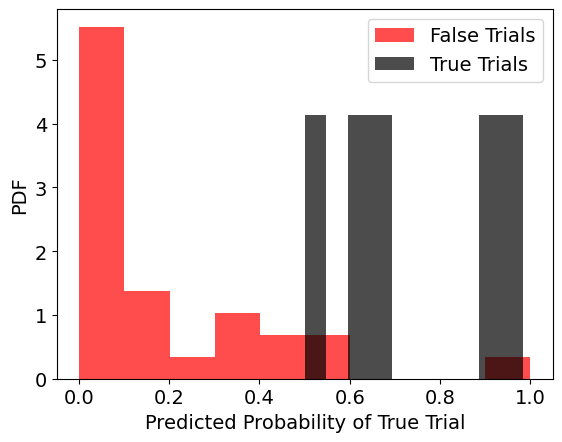

In [59]:
print(f"histogram showing predictions of {y_str=} by {yhat_str=}:")
boo=boo_cv&boonull
label_values= ytest_values[boo].copy()
predictor_values = d_predictions[yhat_str].values[boo].copy()
probas=predictor_values.copy()
ytest=label_values.copy()
plt.hist(probas[ytest==0],color='r', alpha=0.7, label='False Trials',density=True)
plt.hist(probas[ytest==1],color='k', alpha=0.7, label='True Trials',density=True)
# format_plot
format_plot(xlabel='Predicted Probability of True Trial', ylabel='PDF',fontsize=fontsize)
plt.legend(fontsize=fontsize)
print(f"num true trials: {sum(ytest==1)}, num false trials: {sum(ytest==0)}")
plt.show()

In [60]:
#identify the correct/incorrect test trials
threshold=0.5
ypred_values = (d_predictions[yhat_str]>threshold).astype(int).values
ytest_values = (d_predictions[y_str]>threshold).astype(int).values
boonull=~np.isnan(d_predictions[yhat_str])
boo_correct = ypred_values==ytest_values
boo_false_pos_neg = boonull&(~boo_correct)
cv_iter_values = d_predictions['cv_fold_overall'].values

#identify the trials that were predicted incorrrectly
boo_cv = cv_iter_values>-1 # <--> index was a test trial in a fold
boo=boo_cv&boonull
boo_false_pos = (boo_false_pos_neg&boo_cv).values&(ypred_values==1)
boo_false_neg = (boo_false_pos_neg&boo_cv).values&(ypred_values==0)

In [61]:
#generate colored event data
trial_num_values_FP = np.argwhere((boo_false_pos&boo).values[boo_cv]).flatten()
trial_num_values_FN = np.argwhere((boo_false_neg&boo).values[boo_cv]).flatten()
trial_lst = list(np.concatenate((trial_num_values_FP,trial_num_values_FN)))

In [62]:
boonull=d_predictions[yhat_str].isnull()
d_p = d_predictions[~boonull]
label_values = d_p[y_str].values
predictor_values = d_p[yhat_str].values
cv_iter_values = d_predictions[~boonull]['cv_fold_overall'].values
assert cv_iter_values.shape[0]==predictor_values.shape[0]
assert (cv_iter_values>-1).all()

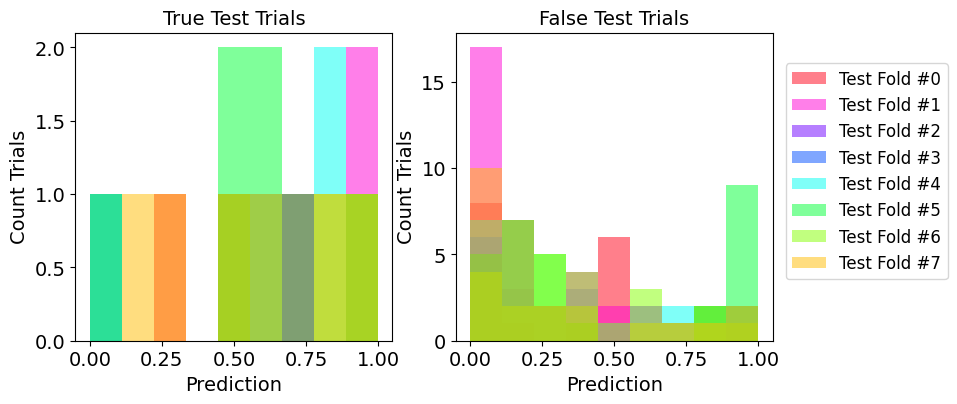

In [63]:
fig,axs=plt.subplots(ncols=2,figsize=(9,4))
ax=axs[0]
bins=np.linspace(0,1,10)
for cv_iter in range(np.max(cv_iter_values)+1):
    axs[0].hist(predictor_values[(cv_iter_values==cv_iter)&(label_values==1)],color=color_dict[cv_iter], alpha=0.5, label=f'Test Fold #{cv_iter}',bins=bins)
    axs[1].hist(predictor_values[(cv_iter_values==cv_iter)&(label_values==0)],color=color_dict[cv_iter], alpha=0.5, label=f'Test Fold #{cv_iter}',bins=bins)
format_plot(ax=axs[0],xlabel='Prediction',ylabel='Count Trials',fontsize=fontsize)
format_plot(ax=axs[1],xlabel='Prediction',ylabel='Count Trials',fontsize=fontsize)
axs[0].set_title('True Test Trials',fontsize=fontsize)
axs[1].set_title('False Test Trials',fontsize=fontsize)
axs[1].legend(fontsize=fontsize-2,loc=(1.04,0.2))
plt.show()

## visualize the ROC trace

In [64]:
#compute overall roc curve
label_values = d_predictions[y_str].values
predictor_values = d_predictions[yhat_str].values
boo = ~np.isnan(predictor_values)
label_values=label_values[boo].copy()
predictor_values=predictor_values[boo].copy()
dict_roc_i = comp_roc_simple(label_values=label_values, predictor_values=predictor_values)
print(f"averaging over the folds, {yhat_str} predicted {y_str} with a testing AUC = {dict_roc_i['auc']:.4f} (N={sum(boo)} trials).")

num_trials=sum(boo)
print(f"{num_trials=}")

averaging over the folds, yhat_i_hermes predicted y_i_hermes with a testing AUC = 0.7395 (N=277 trials).
num_trials=277


In [65]:
conceptName = y_str.split('_')[-1].capitalize()

i_on_i: AUC: 0.7395, num_trials: 277
    ideal threshold: 0.5000 ==> tpr: 0.8372, fpr: 0.2991


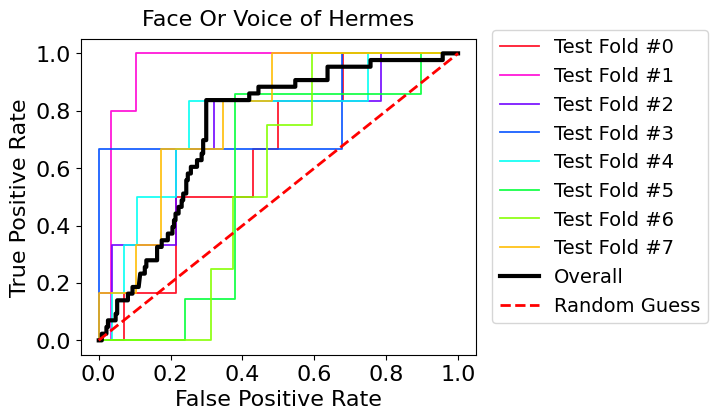

In [66]:
fontsize=16
alpha=0.9
printing=True
fig,ax=plt.subplots(figsize=(5.1,4.1))
#plot ROC traces for each fold
for cv_iter,dict_roc in enumerate(dict_roc_lst):
    tpr = dict_roc['tpr']
    fpr = dict_roc['fpr']
    thresholds = dict_roc['thresholds']
    auc = dict_roc['auc']
    color=color_dict[cv_iter]
    ax.plot(fpr,tpr, label=f"Test Fold #{cv_iter}",lw=1.3,color=color,alpha=0.9)

#plot ROC trace overall 
tpr_i = dict_roc_i['tpr']
fpr_i = dict_roc_i['fpr']
auc_i = dict_roc_i['auc']
thresholds_i = dict_roc_i['thresholds']
ax.plot(fpr_i,tpr_i, label='Overall',lw=3,color='k')

#format_plot
xv=np.linspace(0,1,10)
plt.plot(xv,xv, 'r--',label=f"Random Guess",lw=2,alpha=1.)
format_plot(xlabel='False Positive Rate',ylabel='True Positive Rate',fontsize=fontsize)
plt.legend(fontsize=fontsize-2,loc=(1.04,0.1))
plt.xticks([0,.2,.4,.6,.8,1])
# title=f'Individual Face Or Voice'
title=f'Face Or Voice of {conceptName}'
ax.set_title(title,fontsize=fontsize, loc='center', y=1.1, pad=-13)

index_ideal_thresh_i=np.argmax(tpr_i*(1-fpr_i))
ideal_threshold_i = thresholds_i[index_ideal_thresh_i]
ideal_threshold_i=0.5
print(f"i_on_i: AUC: {auc_i:.4f}, num_trials: {num_trials}")
print(f"    ideal threshold: {ideal_threshold_i:.4f} ==> tpr: {tpr_i[index_ideal_thresh_i]:.4f}, fpr: {fpr_i[index_ideal_thresh_i]:.4f}")
plt.show()

for fold #1, overall testing auc was auc=0.9517.
for fold #2, overall testing auc was auc=0.7381.
for fold #3, overall testing auc was auc=0.7742.
for fold #4, overall testing auc was auc=0.7619.
for fold #7, overall testing auc was auc=0.7874.
i_on_i: AUC: 0.8199, num_trials: 277
    ideal threshold: 0.5000 ==> tpr: 0.8077, fpr: 0.1655


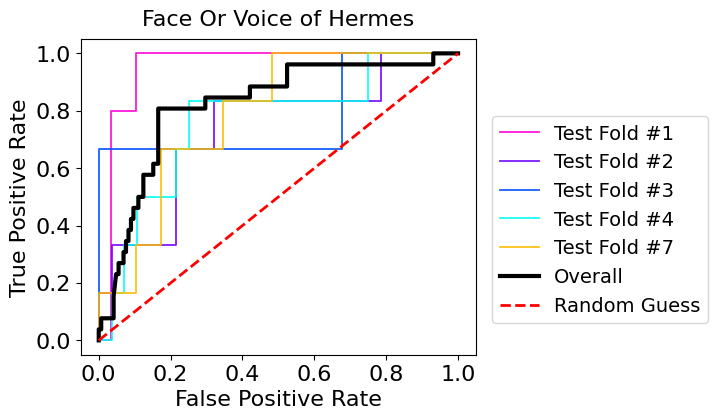

In [67]:
#remake ^that ROC curve using only folds that had an AUC>0.65
min_auc=0.65
fontsize=16
alpha=0.9
printing=True
# fig,ax=plt.subplots(figsize=(6,3.7))
fig,ax=plt.subplots(figsize=(5.1,4.1))
#plot ROC traces for each fold
label_lst=[]
predictor_lst=[]
cv_iter_lst_reasonable=[]
for cv_iter,dict_roc in enumerate(dict_roc_lst):
    tpr = dict_roc['tpr']
    fpr = dict_roc['fpr']
    thresholds = dict_roc['thresholds']
    auc = dict_roc['auc']
    if auc>min_auc:
        print(f"for fold #{cv_iter}, overall testing auc was {auc=:.4f}.")
        color=color_dict[cv_iter]
        ax.plot(fpr,tpr, label=f"Test Fold #{cv_iter}",lw=1.3,color=color,alpha=0.9)
        #record
        label_lst.extend(dict_roc['args']['label_values'])
        predictor_lst.extend(dict_roc['args']['predictor_values'])
        cv_iter_lst_reasonable.append(cv_iter)

#plot ROC trace overall
dict_roc_i_filtered = comp_roc_simple(label_lst, predictor_lst)
tpr_i = dict_roc_i_filtered['tpr'].copy()
fpr_i = dict_roc_i_filtered['fpr'].copy()
auc_i = dict_roc_i_filtered['auc']
thresholds_i = dict_roc_i_filtered['thresholds'].copy()
ax.plot(fpr_i,tpr_i, label='Overall',lw=3,color='k')

#format_plot
xv=np.linspace(0,1,10)
plt.plot(xv,xv, 'r--',label=f"Random Guess",lw=2,alpha=1.)
format_plot(xlabel='False Positive Rate',ylabel='True Positive Rate',fontsize=fontsize)
plt.legend(fontsize=fontsize-2,loc=(1.04,0.1))
plt.xticks([0,.2,.4,.6,.8,1])
conceptName = y_str.split('_')[-1].capitalize()
title=f'Face Or Voice of {conceptName}'
ax.set_title(title,fontsize=fontsize, loc='center', y=1.1, pad=-13)

index_ideal_thresh_i=np.argmax(tpr_i*(1-fpr_i))
ideal_threshold_i = thresholds_i[index_ideal_thresh_i]
ideal_threshold_i = 0.5
print(f"i_on_i: AUC: {auc_i:.4f}, num_trials: {num_trials}")
print(f"    ideal threshold: {ideal_threshold_i:.4f} ==> tpr: {tpr_i[index_ideal_thresh_i]:.4f}, fpr: {fpr_i[index_ideal_thresh_i]:.4f}")
plt.show()

In [68]:
print(f"{session_num=}")
print(f"number of predictors per training fold:")
print(df_results.groupby(by='cv_iter').describe()['auc'][['count']].T.astype(int))
print(df_results.groupby(by='task_str').describe()['auc'][['mean','std','min','max']])
print(f"testing accuracy")
df_results.groupby(by='task_str').describe()['accuracy'][['25%','50%','75%','count']]

session_num=45
number of predictors per training fold:
cv_iter  0  1  2  3  4  5  6  7
count    1  1  1  1  1  1  1  1
              mean       std     min       max
task_str                                      
i_hermes  0.733294  0.135804  0.5625  0.951724
testing accuracy


,25%,50%,75%,count
task_str,,,,
i_hermes,0.675245,0.735294,0.766387,8.0


In [69]:
#print summary statistics of the testing folds
print(f"\t\t*** test results  aggregated over testing folds ***\n")
descr = df_results.describe()
print(f"\n\t\t\t\t\t25%,  50%,  75%,  count")
for col in ['auc','accuracy','sensitivity','precision','negative_predictive_value']:
    print(f"testing {col}:   \t{descr[col][['25%','50%','75%','count']].values}")

print(f"\n\t\t\t\t\t25%,  50%,  75%,  count")
for col in ['num_true_testing','num_false_testing','num_features']:
    print(f"\t\t{col}:   \t{descr[col][['25%','50%','75%','count']].values}")

		*** test results  aggregated over testing folds ***


					25%,  50%,  75%,  count
testing auc:   	[0.62823276 0.75       0.80288283 8.        ]
testing accuracy:   	[0.6752451  0.73529412 0.76638655 8.        ]
testing sensitivity:   	[0.16346154 0.28181818 0.4        8.        ]
testing precision:   	[0.44642857 0.66666667 0.66666667 8.        ]
testing negative_predictive_value:   	[0.71162403 0.76785714 0.80018473 8.        ]

					25%,  50%,  75%,  count
		num_true_testing:   	[4.75 6.   6.   8.  ]
		num_false_testing:   	[28.  29.  29.5  8. ]
		num_features:   	[11.75 13.   14.    8.  ]


## visualize misclassifications in the recording session

In [70]:
show_raw=False
show_all_folds=False
if show_all_folds:
    trial_num_values_involved= df_labels.loc[df_labels['cv_fold']>-1,'trial_num'].values
else:
    boore = False
    assert len(cv_iter_lst_reasonable)>0
    for cv_iter in cv_iter_lst_reasonable:
        boore|= df_labels['cv_fold']==cv_iter
    trial_num_values_involved= df_labels.loc[boore,'trial_num'].values

spike_count_array_ = spike_count_array[trial_num_values_involved]
error_code_array_ = error_code_array[trial_num_values_involved]

if show_raw:
    pred_nid_values=np.unique(df_pred_tbins_agg_raw['nid'].values)
else:
    pred_nid_values=np.unique(df_pred_tbins_agg['nid'].values)

#generate xy coordinate grids
num_trials,_ = error_code_array_.shape
num_neurons = len(pred_nid_values)
xcoord_values = np.arange(num_trials+1)  #as corners of pixels
ycoord_values = np.arange(num_neurons+1) #as corners of pixels
x, y = np.meshgrid(xcoord_values, ycoord_values)
y=y[::-1,::-1].copy() #flip y axis
x=x.copy()
z=spike_count_array_.copy().T[pred_nid_values]
zerr=error_code_array_.copy().T[pred_nid_values]

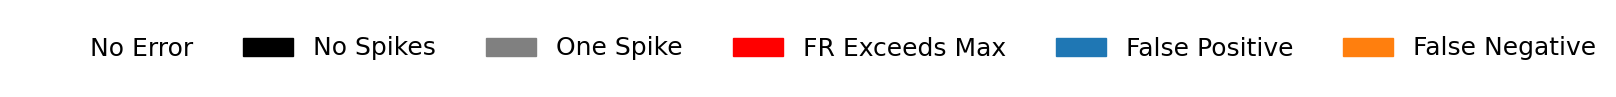

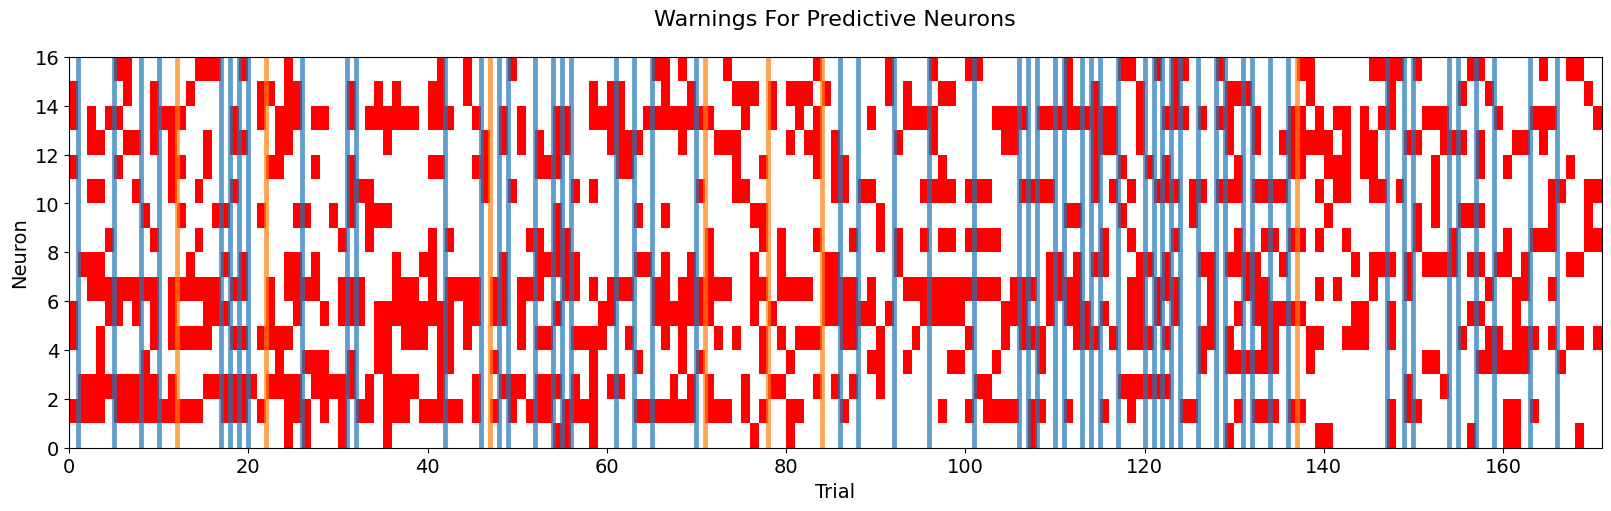

In [71]:
# define discrete color map for error codes
dict_error_labels = {0:'No Error', 1:'No Spikes', 2:'One Spike', 3:'FR Exceeds Max',4:'False Positive',5:'False Negative'}
dict_error_colors = {0:'white', 1:'black', 2:'gray', 3:'red',4:'C0',5:'C1'}
levels=list(dict_error_colors.keys())
levels.append(np.max(levels)+1)
cmap, norm = mpl.colors.from_levels_and_colors(levels=levels, colors=list(dict_error_colors.values()), extend='neither')
# extend : {'neither', 'min', 'max', 'both'}, optional
#make a separate legend for error codes
label_lst=list(dict_error_labels.values())
color_lst=list(dict_error_colors.values())
kwargs_legend={
    'frameon':False,
    'loc':'center',
    'ncol':len(label_lst),
    'fontsize':18,
}
PlotLegend(label_lst=label_lst,color_lst=color_lst,figsize=(1,1),**kwargs_legend);
plt.show()

#visualize heatmap showing error codes of any neuron pair
title = 'Warnings For Predictive Neurons\n'
fontsize=14
figsize=(16,5)
fig, ax = plt.subplots(figsize=figsize,constrained_layout=True)
GridValuePlotter_simple(ax,x,y,zerr,title,cmap,norm,
        fontsize=fontsize,xlabel='Trial',ylabel='Neuron')
num_neurons = x.shape[0]
ax.eventplot([trial_num_values_FP,trial_num_values_FN],color=['C0','C1'],lineoffsets=0,
              linelengths = 2*num_neurons,
              linewidths=3.5,
              alpha=0.7)
plt.show()

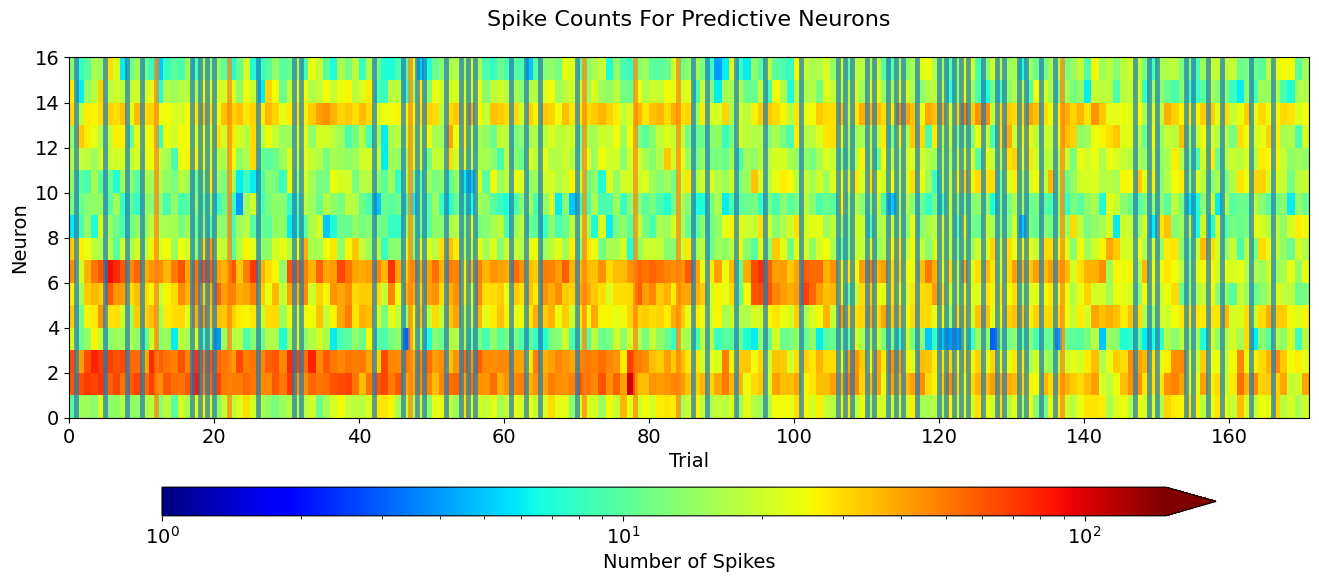

In [72]:
#visualize heatmap showing the number of spikes per trial,neuron pair
title = 'Spike Counts For '
title+= 'Predictive Neurons\n'
vmin=1
vmax=150.
fontsize=14
figsize=(16,6)
cmap='jet'
fig, ax = plt.subplots(figsize=figsize,constrained_layout=True)
ax = GridValuePlotter_colorbar(fig,ax,x,y,z,title,cmap,vmin,vmax,
        fontsize=14,xlabel='Trial',ylabel='Neuron')
num_neurons = x.shape[0]
ax.eventplot([trial_num_values_FP,trial_num_values_FN],color=['C0','C1'],
              lineoffsets=0,
              linelengths = 2*num_neurons,
              linewidths=3.5,
              alpha=0.7)
plt.show()

In [73]:
beep(7)

-n 
-n 
-n 
-n 
-n 
-n 
-n 


0

Such a slow firing rate later on in the session...

...Recalling our anatomical dictionary, one may infer a connection between the above and the trisynaptic circuit model of the hippocampus.

In [74]:
print_dict(data['dict_anatomical'])

session_num=45
anatomical_region='CA1'
AP_pos_set=-3.1
